In [4]:
from KeckLFC.Hardware.Agilent_86142B import Agilent_86142B

osa = Agilent_86142B()
osa.connect()


2024-07-21 13:28:10.139 | INFO     | Device | Device.py:<module>:51
logger initialized
2024-07-21 13:28:11.055 | INFO     | Agilent 86142B | Device.py:connect:78
Agilent 86142B connected


1

In [68]:
osa.wlstart=1553
osa.wlstop=1567
osa.reflevel=-40


2024-07-17 12:21:07.842 | INFO     | Agilent 86142B | Agilent_86142B.py:set_reflevel:109
Agilent 86142B: Reference level set to -40.0 dBm.


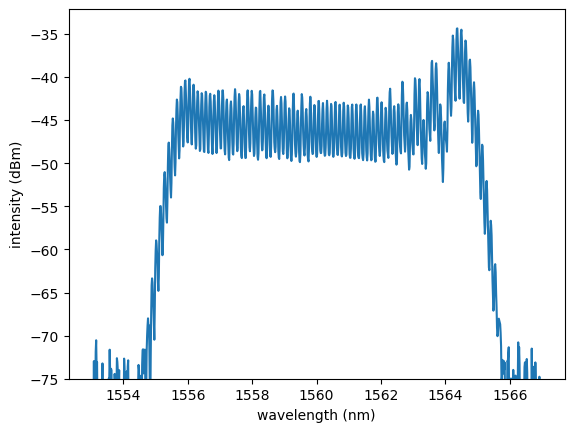

2024-07-21 13:30:18.325 | INFO     | Agilent 86142B | Agilent_86142B.py:get_trace:327
Agilent 86142B: Trace A data is collected and is shown in the plot.


(array([1553.   , 1553.014, 1553.028, ..., 1566.972, 1566.986, 1567.   ],
       dtype=float32),
 array([-79.120125, -79.120125, -79.120125, ..., -78.66582 , -78.95245 ,
        -78.95245 ], dtype=float32))

In [20]:
osa.get_trace('a')

In [3]:
cd ..

c:\Users\KeckLFC\KeckLFC-main


2024-07-17 12:17:11.544 | INFO     | Agilent 86142B | Agilent_86142B.py:set_wlstart:118
Agilent 86142B: Scan start wavelength set to 1553.00 nm.
2024-07-17 12:17:11.836 | INFO     | Agilent 86142B | Agilent_86142B.py:set_wlstop:127
Agilent 86142B: Scan stop wavelength set to 1567.00 nm.


In [66]:
osa.disconnect()

2024-07-17 12:20:58.978 | INFO     | Agilent 86142B | Device.py:disconnect:90
Agilent 86142B disconnected


1

In [1]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is BC2E-EE77

 Directory of c:\Users\KeckLFC\KeckLFC-main\KeckLFC\Notebooks

07/17/2024  08:30 PM    <DIR>          .
07/18/2024  07:02 PM    <DIR>          ..
11/03/2023  12:35 PM            52,871 AndoOSA_test.ipynb
11/03/2023  12:35 PM        11,504,127 Compression_Stage_Test.ipynb
05/27/2024  10:18 AM            47,665 email_test.ipynb
11/03/2023  12:35 PM         3,929,808 Filter-Cavity-Locking-Test.ipynb
03/05/2024  10:43 AM         2,418,222 July_Commission.ipynb
11/03/2023  12:35 PM           451,323 Jun_Commission.ipynb
11/03/2023  12:35 PM           434,279 KeckLFC_class_test.ipynb
02/07/2024  02:07 PM               258 KTL_test.py
11/03/2023  12:35 PM            43,815 LFI-3751_test.ipynb
06/23/2024  06:52 PM           660,357 Minicomb_test_Feb.ipynb
07/17/2024  08:30 PM           914,032 new_laptop_test.ipynb
11/03/2023  12:35 PM             7,469 OZvoaTest.ipynb
11/03/2023  12:35 PM             1,826 pendulum_test.ipyn

In [3]:
cd ..

c:\Users\KeckLFC\KeckLFC-main


In [2]:
cd KeckLFC-main

[WinError 2] The system cannot find the file specified: 'KeckLFC-main'
c:\Users\KeckLFC\KeckLFC-main\KeckLFC\Notebooks


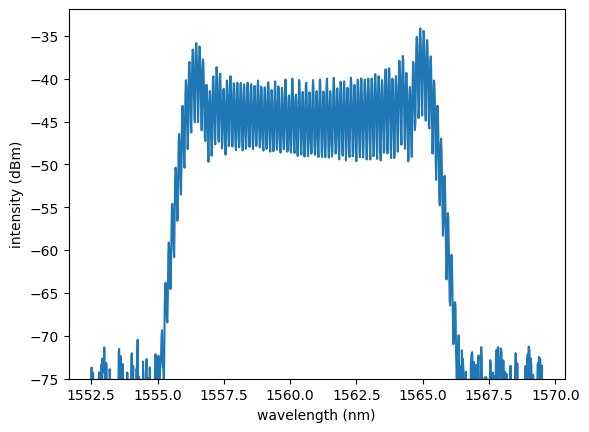

2024-04-16 12:10:30.629 | INFO     | Agilent 86142B | Agilent_86142B.py:get_trace:327
Agilent 86142B: Trace A data is collected and is shown in the plot.


(array([1552.5  , 1552.517, 1552.534, ..., 1569.466, 1569.483, 1569.5  ],
       dtype=float32),
 array([-76.36949, -73.69371, -79.12568, ..., -78.9236 , -78.9236 ,
        -73.49053], dtype=float32))

In [ ]:
# osa.wlstop =1567

osa.get_trace('a')

In [77]:
osa.set_reflevel(-40)

2024-02-22 14:18:32.631 | INFO     | Agilent 86142B | Agilent_86142B.py:set_reflevel:109
Agilent 86142B: Reference level set to -40.0 dBm.


In [70]:
osa.set_resolution(0.05)
osa.get_resolution()

2024-07-17 12:23:41.140 | INFO     | Agilent 86142B | Agilent_86142B.py:set_resolution:160
Agilent 86142B: Resolution set to 0.06 nm.


0.06

In [45]:
osa.write(f'SENS:WAV:STAR {1550:.2f}nm')
osa.get_wlcenter()

1625.0

In [6]:
from KeckLFC.Hardware.AmonicsEDFA import AmonicsEDFA
amonic27 = AmonicsEDFA(addr=f'ASRL{6}::INSTR', name='Amonics EDFA 27 dBm')
amonic27.connect()
amonic27.printStatus()


2024-07-21 13:28:26.455 | INFO     | Amonics EDFA 27 dBm | Device.py:connect:78
Amonics EDFA 27 dBm connected
2024-07-21 13:28:26.766 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:printStatus:49
-------------------------------Amonics EDFA 27 dBm-------------------------------
|--------------------------Amonics EDFA Status Summary---------------------------
|------------------Model: AEDFA-PM-27-R-FA, Serial No.21082531-------------------
|	InterLock Status: UNLOCKED
|	Case Temperature: 24.62°C
|	Master Activation: OFF
|	------------Channel Summary-------------
|	 CHANNEL1: 
|		 Mode: APC
|		 Set Pwr: 450.0 mW
|		 Status: OFF
|		 Input Power: 4.104475 mW
|		 Output Power: 0.0 mW
|		 Internal PD Power: 0.0 mW
------------------------Amonics EDFA Status Summary Ends------------------------



'-------------------------------Amonics EDFA 27 dBm-------------------------------\n|--------------------------Amonics EDFA Status Summary---------------------------\n|------------------Model: AEDFA-PM-27-R-FA, Serial No.21082531-------------------\n|\tInterLock Status: \x1bUNLOCKED\x1b\n|\tCase Temperature: 24.62°C\n|\tMaster Activation: \x1bOFF\x1b\n|\t------------Channel Summary-------------\n|\t CHANNEL1: \n|\t\t Mode: APC\n|\t\t Set Pwr: 450.0 mW\n|\t\t Status: \x1bOFF\x1b\n|\t\t Input Power: 4.104475 mW\n|\t\t Output Power: 0.0 mW\n|\t\t Internal PD Power: 0.0 mW\n------------------------Amonics EDFA Status Summary Ends------------------------\n'

In [41]:
amonic27._setChMode('apc')

2024-07-17 12:12:49.055 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:_setChMode:297
Amonics EDFA 27 dBm: CH1 mode set as apc


In [42]:
amonic27.accCh1Cur='450mw'

2024-07-17 12:13:06.456 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:_setIorP:229
Amonics EDFA 27 dBm: setted APC mode CH1 current as 450.0 mW.


In [7]:
amonic27.accCh1Status = 1
amonic27.activation = 1

2024-07-21 13:28:40.510 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:_setChStatus:278
Amonics EDFA 27 dBm: ......waiting APC CH1 status set to ON, now OFF
2024-07-21 13:28:40.557 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:_setChStatus:281
Amonics EDFA 27 dBm: setted APC CH1 status as ON, finished in 0.080 seconds
2024-07-21 13:28:40.590 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:activation:185
Amonics EDFA 27 dBm: ACTIVATING LASER OUTPUT, MAKE SURE SEED INPUT POWER IS APPROPRIATE TO AVOID DAMAGE
2024-07-21 13:28:40.621 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:activation:192
Amonics EDFA 27 dBm: ......waiting Activation status set to ON, now OFF
2024-07-21 13:28:40.669 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:activation:195
Amonics EDFA 27 dBm: setted Activation status as ON, finished in 0.079 seconds


In [8]:
amonic27.printStatus()

2024-07-21 13:28:44.029 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:printStatus:49
-------------------------------Amonics EDFA 27 dBm-------------------------------
|--------------------------Amonics EDFA Status Summary---------------------------
|------------------Model: AEDFA-PM-27-R-FA, Serial No.21082531-------------------
|	InterLock Status: UNLOCKED
|	Case Temperature: 24.62°C
|	Master Activation: ON
|	------------Channel Summary-------------
|	 CHANNEL1: 
|		 Mode: APC
|		 Set Pwr: 450.0 mW
|		 Status: ON
|		 Input Power: 4.104475 mW
|		 Output Power: 198.4939 mW
|		 Internal PD Power: 316.6311 mW
------------------------Amonics EDFA Status Summary Ends------------------------



'-------------------------------Amonics EDFA 27 dBm-------------------------------\n|--------------------------Amonics EDFA Status Summary---------------------------\n|------------------Model: AEDFA-PM-27-R-FA, Serial No.21082531-------------------\n|\tInterLock Status: \x1bUNLOCKED\x1b\n|\tCase Temperature: 24.62°C\n|\tMaster Activation: \x1bON\x1b\n|\t------------Channel Summary-------------\n|\t CHANNEL1: \n|\t\t Mode: APC\n|\t\t Set Pwr: 450.0 mW\n|\t\t Status: \x1bON\x1b\n|\t\t Input Power: 4.104475 mW\n|\t\t Output Power: 198.4939 mW\n|\t\t Internal PD Power: 316.6311 mW\n------------------------Amonics EDFA Status Summary Ends------------------------\n'

In [44]:
rfoscPS.printStatus()

2024-07-17 12:13:23.962 | INFO     | RF oscilator PS, CH2 15V, CH3 1V | InstekGPD_4303S.py:printStatus:200
-------------------------RF oscilator PS, CH2 15V, CH3 1V------------------------
|----------------Instek DC Power Supply GPD-4303S Status Summary-----------------
|--------------------Model: GPD-4303S, Serial No.SN:EV884423---------------------
|	Master Activation: ON
|	------------Channel Summary-------------
|	 CH1: master, CH2: slave, mode UNRECOGNIZED?.
|	 CHANNEL1: CC Mode.
|		 VSET=0.000V, ISET=0.000A.
|		 VOUT=0.000V, IOUT=0.000A.
|		 Output power: 0.000W.
|	 CHANNEL2: CV Mode.
|		 VSET=15.000V, ISET=3.000A.
|		 VOUT=14.998V, IOUT=0.431A.
|		 Output power: 6.464W.
|	 CHANNEL3: CV Mode.
|		 VSET=0.100V, ISET=1.000A.
|		 VOUT=0.099V, IOUT=0.001A.
|		 Output power: 0.000W.
|	 CHANNEL4: CV Mode.
|		 VSET=0.000V, ISET=0.000A.
|		 VOUT=0.000V, IOUT=0.000A.
|		 Output power: 0.000W.
--------------Instek DC Power Supply GPD-4303S Status Summary Ends--------------



'-------------------------RF oscilator PS, CH2 15V, CH3 1V------------------------\n|----------------Instek DC Power Supply GPD-4303S Status Summary-----------------\n|--------------------Model: GPD-4303S, Serial No.SN:EV884423---------------------\n|\tMaster Activation: \x1bON\x1b\n|\t------------Channel Summary-------------\n|\t CH1: master, CH2: slave, mode UNRECOGNIZED?.\n|\t CHANNEL1: CC Mode.\n|\t\t VSET=0.000V, ISET=0.000A.\n|\t\t VOUT=0.000V, IOUT=0.000A.\n|\t\t Output power: 0.000W.\n|\t CHANNEL2: CV Mode.\n|\t\t VSET=15.000V, ISET=3.000A.\n|\t\t VOUT=14.998V, IOUT=0.431A.\n|\t\t Output power: 6.464W.\n|\t CHANNEL3: CV Mode.\n|\t\t VSET=0.100V, ISET=1.000A.\n|\t\t VOUT=0.099V, IOUT=0.001A.\n|\t\t Output power: 0.000W.\n|\t CHANNEL4: CV Mode.\n|\t\t VSET=0.000V, ISET=0.000A.\n|\t\t VOUT=0.000V, IOUT=0.000A.\n|\t\t Output power: 0.000W.\n--------------Instek DC Power Supply GPD-4303S Status Summary Ends--------------\n'

In [10]:
from KeckLFC.Hardware.InstekGPD_4303S import InstekGPD_4303S
rfoscPS = InstekGPD_4303S(addr='ASRL13::INSTR', name='RF oscilator PS, CH2 15V, CH3 1V')
rfoscPS.connect()
rfoscPS.printStatus()

2024-07-21 13:28:59.032 | INFO     | RF oscilator PS, CH2 15V, CH3 1V | Device.py:connect:78
RF oscilator PS, CH2 15V, CH3 1V connected
2024-07-21 13:29:02.224 | INFO     | RF oscilator PS, CH2 15V, CH3 1V | InstekGPD_4303S.py:printStatus:200
-------------------------RF oscilator PS, CH2 15V, CH3 1V------------------------
|----------------Instek DC Power Supply GPD-4303S Status Summary-----------------
|--------------------Model: GPD-4303S, Serial No.SN:EV884423---------------------
|	Master Activation: OFF
|	------------Channel Summary-------------
|	 CH1: master, CH2: slave, mode UNRECOGNIZED?.
|	 CHANNEL1: CC Mode.
|		 VSET=0.000V, ISET=0.000A.
|		 VOUT=0.000V, IOUT=0.000A.
|		 Output power: 0.000W.
|	 CHANNEL2: CC Mode.
|		 VSET=15.000V, ISET=3.000A.
|		 VOUT=0.000V, IOUT=0.000A.
|		 Output power: 0.000W.
|	 CHANNEL3: CC Mode.
|		 VSET=0.620V, ISET=1.000A.
|		 VOUT=0.000V, IOUT=0.000A.
|		 Output power: 0.000W.
|	 CHANNEL4: CV Mode.
|		 VSET=0.000V, ISET=0.000A.
|		 VOUT=0.000V, I

'-------------------------RF oscilator PS, CH2 15V, CH3 1V------------------------\n|----------------Instek DC Power Supply GPD-4303S Status Summary-----------------\n|--------------------Model: GPD-4303S, Serial No.SN:EV884423---------------------\n|\tMaster Activation: \x1bOFF\x1b\n|\t------------Channel Summary-------------\n|\t CH1: master, CH2: slave, mode UNRECOGNIZED?.\n|\t CHANNEL1: CC Mode.\n|\t\t VSET=0.000V, ISET=0.000A.\n|\t\t VOUT=0.000V, IOUT=0.000A.\n|\t\t Output power: 0.000W.\n|\t CHANNEL2: CC Mode.\n|\t\t VSET=15.000V, ISET=3.000A.\n|\t\t VOUT=0.000V, IOUT=0.000A.\n|\t\t Output power: 0.000W.\n|\t CHANNEL3: CC Mode.\n|\t\t VSET=0.620V, ISET=1.000A.\n|\t\t VOUT=0.000V, IOUT=0.000A.\n|\t\t Output power: 0.000W.\n|\t CHANNEL4: CV Mode.\n|\t\t VSET=0.000V, ISET=0.000A.\n|\t\t VOUT=0.000V, IOUT=0.000A.\n|\t\t Output power: 0.000W.\n--------------Instek DC Power Supply GPD-4303S Status Summary Ends--------------\n'

In [138]:
rfoscPS.printStatus()

2024-07-20 15:13:45.883 | INFO     | RF oscilator PS, CH2 15V, CH3 1V | InstekGPD_4303S.py:printStatus:200
-------------------------RF oscilator PS, CH2 15V, CH3 1V------------------------
|----------------Instek DC Power Supply GPD-4303S Status Summary-----------------
|--------------------Model: GPD-4303S, Serial No.SN:EV884423---------------------
|	Master Activation: OFF
|	------------Channel Summary-------------
|	 CH1: master, CH2: slave, mode UNRECOGNIZED?.
|	 CHANNEL1: CC Mode.
|		 VSET=0.000V, ISET=0.000A.
|		 VOUT=0.000V, IOUT=0.000A.
|		 Output power: 0.000W.
|	 CHANNEL2: CC Mode.
|		 VSET=15.000V, ISET=3.000A.
|		 VOUT=0.000V, IOUT=0.000A.
|		 Output power: 0.000W.
|	 CHANNEL3: CC Mode.
|		 VSET=0.620V, ISET=1.000A.
|		 VOUT=0.000V, IOUT=0.000A.
|		 Output power: 0.000W.
|	 CHANNEL4: CV Mode.
|		 VSET=0.000V, ISET=0.000A.
|		 VOUT=0.000V, IOUT=0.000A.
|		 Output power: 0.000W.
--------------Instek DC Power Supply GPD-4303S Status Summary Ends--------------



'-------------------------RF oscilator PS, CH2 15V, CH3 1V------------------------\n|----------------Instek DC Power Supply GPD-4303S Status Summary-----------------\n|--------------------Model: GPD-4303S, Serial No.SN:EV884423---------------------\n|\tMaster Activation: \x1bOFF\x1b\n|\t------------Channel Summary-------------\n|\t CH1: master, CH2: slave, mode UNRECOGNIZED?.\n|\t CHANNEL1: CC Mode.\n|\t\t VSET=0.000V, ISET=0.000A.\n|\t\t VOUT=0.000V, IOUT=0.000A.\n|\t\t Output power: 0.000W.\n|\t CHANNEL2: CC Mode.\n|\t\t VSET=15.000V, ISET=3.000A.\n|\t\t VOUT=0.000V, IOUT=0.000A.\n|\t\t Output power: 0.000W.\n|\t CHANNEL3: CC Mode.\n|\t\t VSET=0.620V, ISET=1.000A.\n|\t\t VOUT=0.000V, IOUT=0.000A.\n|\t\t Output power: 0.000W.\n|\t CHANNEL4: CV Mode.\n|\t\t VSET=0.000V, ISET=0.000A.\n|\t\t VOUT=0.000V, IOUT=0.000A.\n|\t\t Output power: 0.000W.\n--------------Instek DC Power Supply GPD-4303S Status Summary Ends--------------\n'

In [85]:
rfoscPS.activation = 0

2024-07-21 14:21:48.759 | INFO     | RF oscilator PS, CH2 15V, CH3 1V | InstekGPD_4303S.py:activation:44
Instek GPD-4303S DCSupply: Output activation is turned OFF.


In [12]:
from KeckLFC.Hardware.InstekGppDCSupply import InstekGppDCSupply

rfampPS = InstekGppDCSupply(addr=f'ASRL{24}::INSTR', name='RF amplifier PS 30V 4A')
rfampPS.connect()
rfampPS.printStatus()


2024-07-21 13:29:12.753 | INFO     | RF amplifier PS 30V 4A | Device.py:connect:78
RF amplifier PS 30V 4A connected
2024-07-21 13:29:12.894 | INFO     | RF amplifier PS 30V 4A | InstekGppDCSupply.py:printStatus:56
------------------------------RF amplifier PS 30V 4A-----------------------------
|-------------------Instek GPP DC Power Supply Status Summary--------------------
|--------------------Model: GPP-1326, Serial No.SN:GET842785---------------------
|	------------Channel Summary-------------
|	 CHANNEL1: Activation OFF.
|		 VSET=30.000V, ISET=4.200A.
|		 VOUT=0.000V, IOUT=0.000A.
|		 Output power: 0.000W.
|		 ---Over Voltage/Current Protection Status:---
|		 OVP Status: OFF	 OCP Status: OFF 
|		 OVP Level : 35.0 V	 OCP Level : 7.0 A
-----------------Instek GPP DC Power Supply Status Summary Ends-----------------



'------------------------------RF amplifier PS 30V 4A-----------------------------\n|-------------------Instek GPP DC Power Supply Status Summary--------------------\n|--------------------Model: GPP-1326, Serial No.SN:GET842785---------------------\n|\t------------Channel Summary-------------\n|\t CHANNEL1: Activation \x1bOFF\x1b.\n|\t\t VSET=30.000V, ISET=4.200A.\n|\t\t VOUT=0.000V, IOUT=0.000A.\n|\t\t Output power: 0.000W.\n|\t\t ---Over Voltage/Current Protection Status:---\n|\t\t OVP Status: OFF\t OCP Status: OFF \n|\t\t OVP Level : 35.0 V\t OCP Level : 7.0 A\n-----------------Instek GPP DC Power Supply Status Summary Ends-----------------\n'

In [28]:
rfampPS.Vset1=30
rfampPS.Iset1=4.2

2024-07-17 12:09:11.139 | INFO     | RF amplifier PS 30V 4A | InstekGppDCSupply.py:_setVSET:284
RF amplifier PS 30V 4A: VSET channel 1 set to 30.000V
2024-07-17 12:09:11.173 | INFO     | RF amplifier PS 30V 4A | InstekGppDCSupply.py:_setISET:260
RF amplifier PS 30V 4A: ISET channel 1 set to 4.200A


In [87]:
rfampPS.activation1 = 0


2024-07-21 14:21:58.568 | INFO     | RF amplifier PS 30V 4A | InstekGppDCSupply.py:_setOutputStatus:237
RF amplifier PS 30V 4A: channel 1 output is turned OFF


In [86]:
rfampPS.printStatus()

2024-07-21 14:21:52.821 | INFO     | RF amplifier PS 30V 4A | InstekGppDCSupply.py:printStatus:56
------------------------------RF amplifier PS 30V 4A-----------------------------
|-------------------Instek GPP DC Power Supply Status Summary--------------------
|--------------------Model: GPP-1326, Serial No.SN:GET842785---------------------
|	------------Channel Summary-------------
|	 CHANNEL1: Activation ON.
|		 VSET=30.000V, ISET=4.200A.
|		 VOUT=29.995V, IOUT=0.753A.
|		 Output power: 22.580W.
|		 ---Over Voltage/Current Protection Status:---
|		 OVP Status: OFF	 OCP Status: OFF 
|		 OVP Level : 35.0 V	 OCP Level : 7.0 A
-----------------Instek GPP DC Power Supply Status Summary Ends-----------------



'------------------------------RF amplifier PS 30V 4A-----------------------------\n|-------------------Instek GPP DC Power Supply Status Summary--------------------\n|--------------------Model: GPP-1326, Serial No.SN:GET842785---------------------\n|\t------------Channel Summary-------------\n|\t CHANNEL1: Activation \x1bON\x1b.\n|\t\t VSET=30.000V, ISET=4.200A.\n|\t\t VOUT=29.995V, IOUT=0.753A.\n|\t\t Output power: 22.580W.\n|\t\t ---Over Voltage/Current Protection Status:---\n|\t\t OVP Status: OFF\t OCP Status: OFF \n|\t\t OVP Level : 35.0 V\t OCP Level : 7.0 A\n-----------------Instek GPP DC Power Supply Status Summary Ends-----------------\n'

In [84]:
from KeckLFC.Hardware.AmonicsEDFA import AmonicsEDFA
amonic27 = AmonicsEDFA(addr=f'ASRL{6}::INSTR', name='Amonics EDFA 27 dBm')
amonic27.connect()
amonic27.printStatus()

2024-07-21 14:21:31.582 | INFO     | Amonics EDFA 27 dBm | Device.py:connect:78
Amonics EDFA 27 dBm connected
2024-07-21 14:21:31.890 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:printStatus:49
-------------------------------Amonics EDFA 27 dBm-------------------------------
|--------------------------Amonics EDFA Status Summary---------------------------
|------------------Model: AEDFA-PM-27-R-FA, Serial No.21082531-------------------
|	InterLock Status: UNLOCKED
|	Case Temperature: 26.52°C
|	Master Activation: OFF
|	------------Channel Summary-------------
|	 CHANNEL1: 
|		 Mode: APC
|		 Set Pwr: 450.0 mW
|		 Status: OFF
|		 Input Power: 4.081452 mW
|		 Output Power: 0.0 mW
|		 Internal PD Power: 0.0 mW
------------------------Amonics EDFA Status Summary Ends------------------------



'-------------------------------Amonics EDFA 27 dBm-------------------------------\n|--------------------------Amonics EDFA Status Summary---------------------------\n|------------------Model: AEDFA-PM-27-R-FA, Serial No.21082531-------------------\n|\tInterLock Status: \x1bUNLOCKED\x1b\n|\tCase Temperature: 26.52°C\n|\tMaster Activation: \x1bOFF\x1b\n|\t------------Channel Summary-------------\n|\t CHANNEL1: \n|\t\t Mode: APC\n|\t\t Set Pwr: 450.0 mW\n|\t\t Status: \x1bOFF\x1b\n|\t\t Input Power: 4.081452 mW\n|\t\t Output Power: 0.0 mW\n|\t\t Internal PD Power: 0.0 mW\n------------------------Amonics EDFA Status Summary Ends------------------------\n'

In [83]:
amonic27.accCh1Cur = '450mA'
amonic27.accCh1Status = 0
amonic27.activation = 0


2024-07-21 14:21:27.410 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:_setIorP:229
Amonics EDFA 27 dBm: setted APC mode CH1 current as 450.0 mW.
2024-07-21 14:21:27.442 | WARNING  | Amonics EDFA 27 dBm | AmonicsEDFA.py:_setChStatus:268
Amonics EDFA 27 dBm: Setting APC CH1 status OFF while activation ON will automatically OFF the activation. Add self.activation='off' before self.accCh1Status='off' 
c:\Users\KeckLFC\KeckLFC-main\KeckLFC\Hardware\Device.py:116: UserWarning: Amonics EDFA 27 dBm: Setting APC CH1 status OFF while activation ON will automatically OFF the activation. Add self.activation='off' before self.accCh1Status='off' 
  warnings.warn(x)
2024-07-21 14:21:27.475 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:_setChStatus:278
Amonics EDFA 27 dBm: ......waiting APC CH1 status set to OFF, now ON
2024-07-21 14:21:27.522 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:_setChStatus:281
Amonics EDFA 27 dBm: setted APC CH1 status as OFF, finished in 0.078 seconds
2024-07-

In [133]:
amonic27.printStatus()

2024-07-20 14:53:33.276 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:printStatus:49
-------------------------------Amonics EDFA 27 dBm-------------------------------
|--------------------------Amonics EDFA Status Summary---------------------------
|------------------Model: AEDFA-PM-27-R-FA, Serial No.21082531-------------------
|	InterLock Status: UNLOCKED
|	Case Temperature: 26.32°C
|	Master Activation: OFF
|	------------Channel Summary-------------
|	 CHANNEL1: 
|		 Mode: APC
|		 Set Pwr: 450.0 mW
|		 Status: OFF
|		 Input Power: 6.945065 mW
|		 Output Power: 0.0 mW
|		 Internal PD Power: 0.0 mW
------------------------Amonics EDFA Status Summary Ends------------------------



'-------------------------------Amonics EDFA 27 dBm-------------------------------\n|--------------------------Amonics EDFA Status Summary---------------------------\n|------------------Model: AEDFA-PM-27-R-FA, Serial No.21082531-------------------\n|\tInterLock Status: \x1bUNLOCKED\x1b\n|\tCase Temperature: 26.32°C\n|\tMaster Activation: \x1bOFF\x1b\n|\t------------Channel Summary-------------\n|\t CHANNEL1: \n|\t\t Mode: APC\n|\t\t Set Pwr: 450.0 mW\n|\t\t Status: \x1bOFF\x1b\n|\t\t Input Power: 6.945065 mW\n|\t\t Output Power: 0.0 mW\n|\t\t Internal PD Power: 0.0 mW\n------------------------Amonics EDFA Status Summary Ends------------------------\n'

In [18]:
amonic27.inputPowerCh1

0.0

In [16]:
osa.get_trace('a')

NameError: name 'osa' is not defined

In [64]:
import numpy as np
import time
import smtplib

import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def score_eo_comb(osa):
    
    osa.wlstart=1553
    osa.wlstop=1567
    osa.reflevel=-40
    osa.set_resolution(0.06)
    
    osa.Single()
    time.sleep(0.5)
    x,y=osa.get_trace('a')

    
    #x1=x[np.where((x>start_wl) & (x<stop_wl))] 
    y1=y[np.where((x>1553) & (x<1567))]
    
    hight_shreshold=-50
    peaks,_ = find_peaks(y1, height=hight_shreshold, distance=2, width=0.02e-9)
    num_peaks = len(peaks)

    score=np.std(y1[peaks])*-1
    return score

In [56]:
osa.Single()

2024-07-21 14:08:37.686 | INFO     | Agilent 86142B | Agilent_86142B.py:Single:168
Agilent 86142B: Spectrum collection SINGLE run start.


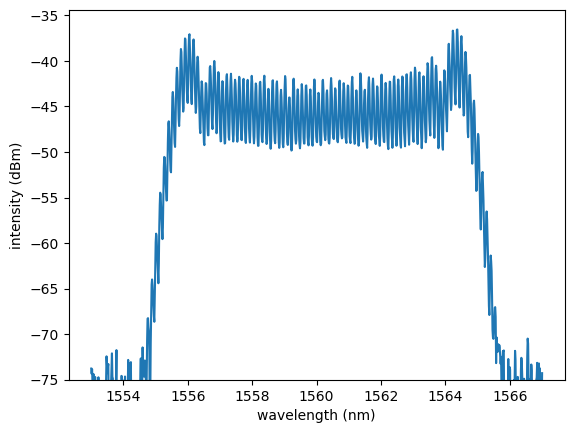

2024-07-21 14:09:18.419 | INFO     | Agilent 86142B | Agilent_86142B.py:get_trace:327
Agilent 86142B: Trace A data is collected and is shown in the plot.


In [59]:
x,y=osa.get_trace('a')

In [80]:
peaks,_ = find_peaks(y, height=-50, distance=2,width=0.02e-9)

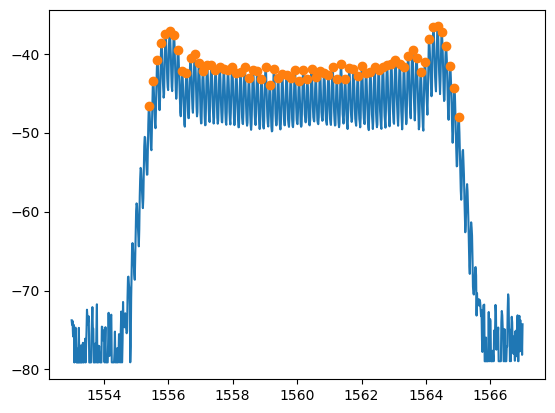

In [78]:
plt.plot(x,y)
plt.plot(x[peaks],y[peaks],'o')

2024-07-21 14:09:36.491 | INFO     | Agilent 86142B | Agilent_86142B.py:set_wlstart:118
Agilent 86142B: Scan start wavelength set to 1553.00 nm.
2024-07-21 14:09:36.778 | INFO     | Agilent 86142B | Agilent_86142B.py:set_wlstop:127
Agilent 86142B: Scan stop wavelength set to 1567.00 nm.
2024-07-21 14:09:37.013 | INFO     | Agilent 86142B | Agilent_86142B.py:set_reflevel:109
Agilent 86142B: Reference level set to -40.0 dBm.
2024-07-21 14:09:37.264 | INFO     | Agilent 86142B | Agilent_86142B.py:set_resolution:160
Agilent 86142B: Resolution set to 0.06 nm.
2024-07-21 14:09:37.268 | INFO     | Agilent 86142B | Agilent_86142B.py:Single:168
Agilent 86142B: Spectrum collection SINGLE run start.


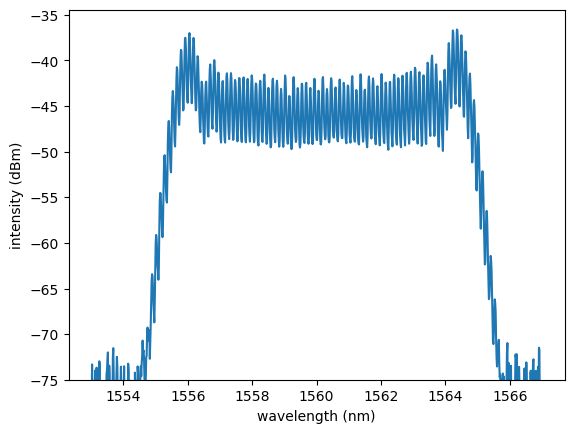

2024-07-21 14:09:38.445 | INFO     | Agilent 86142B | Agilent_86142B.py:get_trace:327
Agilent 86142B: Trace A data is collected and is shown in the plot.


-1.9384628534317017

In [62]:
score_eo_comb(osa)

2024-07-21 14:04:52.843 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:__set_num_withcmd:812
Minicomb Intensity Lock Servo: Setting Output in Manual Mode in Volt to -0.32.
2024-07-21 14:04:53.314 | INFO     | RF oscilator PS, CH2 15V, CH3 1V | InstekGPD_4303S.py:_setVSET:320
Instek GPD-4303S DCSupply: VSET channel 3 set to 0.620V
2024-07-21 14:04:54.318 | INFO     | Agilent 86142B | Agilent_86142B.py:Run:164
Agilent 86142B: Spectrum collection RUN (repeat) start.


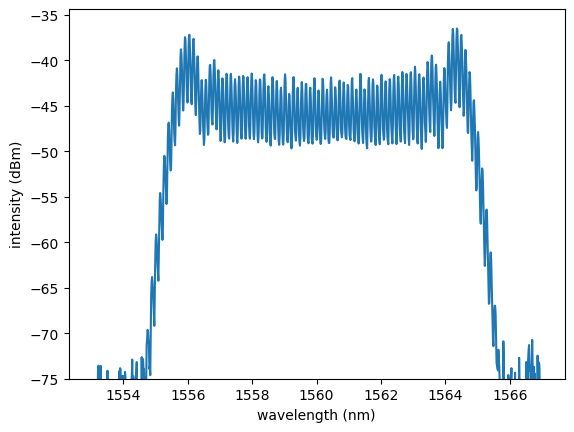

2024-07-21 14:04:55.188 | INFO     | Agilent 86142B | Agilent_86142B.py:get_trace:327
Agilent 86142B: Trace A data is collected and is shown in the plot.


(array([1553.   , 1553.014, 1553.028, ..., 1566.972, 1566.986, 1567.   ],
       dtype=float32),
 array([-77.52061, -76.13229, -76.61463, ..., -77.95299, -78.95245,
        -78.95245], dtype=float32))

In [48]:
import time
servo_IM.manual_output = -0.32
rfoscPS.Vset3=0.62
time.sleep(1)
osa.Run()
osa.get_trace('a')
# import time
# time.sleep(1)
# osa.get_trace('a')

In [82]:
from KeckLFC.Hardware.AmonicsEDFA import AmonicsEDFA
amonic23 = AmonicsEDFA(addr=f'ASRL{12}::INSTR', name='Amonics EDFA 23 dBm')
amonic23.connect()
amonic23.printStatus()

2024-07-21 14:21:04.267 | INFO     | Amonics EDFA 23 dBm | Device.py:connect:78
Amonics EDFA 23 dBm connected
2024-07-21 14:21:10.544 | INFO     | Amonics EDFA 23 dBm | AmonicsEDFA.py:printStatus:49
-------------------------------Amonics EDFA 23 dBm-------------------------------
|--------------------------Amonics EDFA Status Summary---------------------------
|------------------Model: AEDFA-PM-23-R-FA, Serial No.22020702-------------------
|	InterLock Status: UNLOCKED
|	Case Temperature: 29.69°C
|	Master Activation: OFF
|	------------Channel Summary-------------
|	 CHANNEL1: 
|		 Mode: ACC
|		 Set Cur: 80.0 mA
|		 Status: OFF
|		 Input Power: 2.416553 mW
|		 Output Power: 0.0 mW
|		 Internal PD Power: 0.0 mW
------------------------Amonics EDFA Status Summary Ends------------------------



'-------------------------------Amonics EDFA 23 dBm-------------------------------\n|--------------------------Amonics EDFA Status Summary---------------------------\n|------------------Model: AEDFA-PM-23-R-FA, Serial No.22020702-------------------\n|\tInterLock Status: \x1bUNLOCKED\x1b\n|\tCase Temperature: 29.69°C\n|\tMaster Activation: \x1bOFF\x1b\n|\t------------Channel Summary-------------\n|\t CHANNEL1: \n|\t\t Mode: ACC\n|\t\t Set Cur: 80.0 mA\n|\t\t Status: \x1bOFF\x1b\n|\t\t Input Power: 2.416553 mW\n|\t\t Output Power: 0.0 mW\n|\t\t Internal PD Power: 0.0 mW\n------------------------Amonics EDFA Status Summary Ends------------------------\n'

In [44]:
amonic23.accCh1Cur = '80mA'
amonic23.accCh1Status = 0
amonic23.activation = 0

2024-07-21 14:04:04.303 | INFO     | Amonics EDFA 23 dBm | AmonicsEDFA.py:_setIorP:227
Amonics EDFA 23 dBm: setted ACC mode CH1 current as 80.0 mA.
2024-07-21 14:04:06.319 | WARNING  | Amonics EDFA 23 dBm | AmonicsEDFA.py:_setChStatus:268
Amonics EDFA 23 dBm: Setting ACC CH1 status OFF while activation ON will automatically OFF the activation. Add self.activation='off' before self.accCh1Status='off' 
c:\Users\KeckLFC\KeckLFC-main\KeckLFC\Hardware\Device.py:116: UserWarning: Amonics EDFA 23 dBm: Setting ACC CH1 status OFF while activation ON will automatically OFF the activation. Add self.activation='off' before self.accCh1Status='off' 
  warnings.warn(x)
2024-07-21 14:04:06.351 | INFO     | Amonics EDFA 23 dBm | AmonicsEDFA.py:_setChStatus:278
Amonics EDFA 23 dBm: ......waiting ACC CH1 status set to OFF, now ON
2024-07-21 14:04:06.398 | INFO     | Amonics EDFA 23 dBm | AmonicsEDFA.py:_setChStatus:281
Amonics EDFA 23 dBm: setted ACC CH1 status as OFF, finished in 0.078 seconds
2024-07-2

In [45]:
#time.sleep(3)
amonic23.printStatus()

2024-07-21 14:04:21.007 | INFO     | Amonics EDFA 23 dBm | AmonicsEDFA.py:printStatus:49
-------------------------------Amonics EDFA 23 dBm-------------------------------
|--------------------------Amonics EDFA Status Summary---------------------------
|------------------Model: AEDFA-PM-23-R-FA, Serial No.22020702-------------------
|	InterLock Status: UNLOCKED
|	Case Temperature: 29.62°C
|	Master Activation: OFF
|	------------Channel Summary-------------
|	 CHANNEL1: 
|		 Mode: ACC
|		 Set Cur: 80.0 mA
|		 Status: OFF
|		 Input Power: 2.21964 mW
|		 Output Power: 0.0 mW
|		 Internal PD Power: 0.0 mW
------------------------Amonics EDFA Status Summary Ends------------------------



'-------------------------------Amonics EDFA 23 dBm-------------------------------\n|--------------------------Amonics EDFA Status Summary---------------------------\n|------------------Model: AEDFA-PM-23-R-FA, Serial No.22020702-------------------\n|\tInterLock Status: \x1bUNLOCKED\x1b\n|\tCase Temperature: 29.62°C\n|\tMaster Activation: \x1bOFF\x1b\n|\t------------Channel Summary-------------\n|\t CHANNEL1: \n|\t\t Mode: ACC\n|\t\t Set Cur: 80.0 mA\n|\t\t Status: \x1bOFF\x1b\n|\t\t Input Power: 2.21964 mW\n|\t\t Output Power: 0.0 mW\n|\t\t Internal PD Power: 0.0 mW\n------------------------Amonics EDFA Status Summary Ends------------------------\n'

In [23]:
from KeckLFC.Hardware.Arduino_relay import Arduino_relay
arduino = Arduino_relay(addr="COM3")
# print(f'com={i}')
arduino.connect()
arduino.printStatus()


2024-07-21 13:30:55.725 | INFO     | Arduino Relay Circuit | Arduino_relay.py:connect:52
Arduino Relay Circuit connected
2024-07-21 13:30:56.127 | INFO     | Arduino Relay Circuit | Arduino_relay.py:query:90
Arduino Relay Circuit: Failed to query get, trial num 1, trying again
2024-07-21 13:30:56.332 | INFO     | Arduino Relay Circuit | Arduino_relay.py:query:90
Arduino Relay Circuit: Failed to query get, trial num 2, trying again
2024-07-21 13:30:56.535 | INFO     | Arduino Relay Circuit | Arduino_relay.py:query:90
Arduino Relay Circuit: Failed to query get, trial num 3, trying again
2024-07-21 13:30:56.941 | INFO     | Arduino Relay Circuit | Arduino_relay.py:printStatus:43
----------------------Arduino Relay Module Status Summary-----------------------
|	 Relay Status: relay is  STOPPING  amplifier, but will be  OK_to_Amplify  after reset_relay_latch.
|	 Relay Info: get
|		Now voltage is 562
|		Now voltage to judge (low) is 0
|		Now voltage to judge (high) is 1024
|		Low Threshold i

'----------------------Arduino Relay Module Status Summary-----------------------\n|\t Relay Status: relay is \x1b STOPPING \x1b amplifier, but will be \x1b OK_to_Amplify \x1b after reset_relay_latch.\n|\t Relay Info: get\r\r\n|\t\tNow voltage is 562\r\n|\t\tNow voltage to judge (low) is 0\r\n|\t\tNow voltage to judge (high) is 1024\r\n|\t\tLow Threshold is 317\r\n|\t\tHigh Threshold is 690\n|\t YJ Shutter State: YJState\r\r\n|\t\tYJ shutter is DOWN, YJ is \x1b passing \x1b.\n--------------------Arduino Relay Module Status Summary Ends--------------------'

In [24]:
arduino.reset_relay_latch()

'reset\r\r\nNow voltage is reset equal to input，and the voltage is:563'

In [182]:
message=arduino.get_YJ_info()
            
if message in ['YJState\r\r\nYJ shutter is UP, YJ is shutted.']:
                message = 0
if message in ['YJState\r\r\nYJ shutter is DOWN, YJ is passing.']:
                message = 1

print(message)

1


In [64]:
arduino.shut_YJ()

'YJShut\r\r\nYJ shutter is UP, YJ is shutted.'

In [195]:
arduino.disconnect()

2024-07-19 10:53:50.174 | INFO     | Arduino Relay Circuit | Arduino_relay.py:disconnect:65
Arduino Relay Circuit disconnected


1

In [ ]:
arduino.pass_YJ()

In [89]:
arduino.disconnect()

2024-07-21 14:23:22.263 | INFO     | Arduino Relay Circuit | Arduino_relay.py:disconnect:65
Arduino Relay Circuit disconnected


1

In [25]:
arduino.printStatus()

2024-07-21 13:31:06.560 | INFO     | Arduino Relay Circuit | Arduino_relay.py:printStatus:43
----------------------Arduino Relay Module Status Summary-----------------------
|	 Relay Status: relay sending  OK_to_Amplify  signal to amplifier
|	 Relay Info: get
|		Now voltage is 585
|		Now voltage to judge (low) is 563
|		Now voltage to judge (high) is 586
|		Low Threshold is 317
|		High Threshold is 690
|	 YJ Shutter State: YJState
|		YJ shutter is DOWN, YJ is  passing .
--------------------Arduino Relay Module Status Summary Ends--------------------


'----------------------Arduino Relay Module Status Summary-----------------------\n|\t Relay Status: relay sending \x1b OK_to_Amplify \x1b signal to amplifier\n|\t Relay Info: get\r\r\n|\t\tNow voltage is 585\r\n|\t\tNow voltage to judge (low) is 563\r\n|\t\tNow voltage to judge (high) is 586\r\n|\t\tLow Threshold is 317\r\n|\t\tHigh Threshold is 690\n|\t YJ Shutter State: YJState\r\r\n|\t\tYJ shutter is DOWN, YJ is \x1b passing \x1b.\n--------------------Arduino Relay Module Status Summary Ends--------------------'

In [153]:
arduino.get_YJ_info()

'YJState\r\r\nYJ shutter is UP, YJ is shutted.'

In [113]:
arduino.query("YJState")

'YJState\r\r\nYJ shutter is UP, YJ is shutted.'

In [152]:
arduino.shut_YJ()

'YJShut\r\r\nYJ shutter is UP, YJ is shutted.'

In [13]:
arduino.query('GET')

'GET\r\r\nNow voltage is 4\r\nNow voltage to judge (low) is 0\r\nNow voltage to judge (high) is 1024\r\nLow Threshold is 317\r\nHigh Threshold is 690'

In [119]:
message=arduino.get_YJ_info()

if message in ['YJState\r\r\nYJ shutter is UP, YJ is shutted.']:
    message = 0
if message in ['YJState\r\r\nYJ shutter is DOWN, YJ is passing.']:
    message = 1
# fill in read functions
message

0

In [26]:
from KeckLFC.Hardware.PendulumCNT90 import PendulumCNT90
pendulem = PendulumCNT90()
pendulem.connect()

2024-07-21 13:31:18.734 | INFO     | Pendulum microwave counter | Device.py:connect:78
Pendulum microwave counter connected


1

In [28]:
freq=pendulem.measFreq('c')
freq-16e9

-140.56999969482422

In [12]:
arduino.get_relay_status()

'relay is STOPPING amplifier, because input power is too low'

In [24]:
arduino.reset_relay_latch()
arduino.printStatus()


2024-07-20 10:29:47.890 | INFO     | Arduino Relay Circuit | Arduino_relay.py:printStatus:43
----------------------Arduino Relay Module Status Summary-----------------------
|	 Relay Status: relay sending  OK_to_Amplify  signal to amplifier
|	 Relay Info: get
|		Now voltage is 594
|		Now voltage to judge (low) is 592
|		Now voltage to judge (high) is 595
|		Low Threshold is 317
|		High Threshold is 690
|	 YJ Shutter State: YJState
|		YJ shutter is DOWN, YJ is  passing .
--------------------Arduino Relay Module Status Summary Ends--------------------


'----------------------Arduino Relay Module Status Summary-----------------------\n|\t Relay Status: relay sending \x1b OK_to_Amplify \x1b signal to amplifier\n|\t Relay Info: get\r\r\n|\t\tNow voltage is 594\r\n|\t\tNow voltage to judge (low) is 592\r\n|\t\tNow voltage to judge (high) is 595\r\n|\t\tLow Threshold is 317\r\n|\t\tHigh Threshold is 690\n|\t YJ Shutter State: YJState\r\r\n|\t\tYJ shutter is DOWN, YJ is \x1b passing \x1b.\n--------------------Arduino Relay Module Status Summary Ends--------------------'

In [273]:
arduino.pass_YJ()

'YJPass\r\r\nYJ shutter is DOWN, YJ is passing.'

In [70]:
arduino.printStatus()

2024-04-17 12:42:56.147 | INFO     | Arduino Relay Circuit | Arduino_relay.py:printStatus:43
----------------------Arduino Relay Module Status Summary-----------------------
|	 Relay Status: relay is  STOPPING  amplifier, but will be  OK_to_Amplify  after reset_relay_latch.
|	 Relay Info: get
|		Now voltage is 568
|		Now voltage to judge (low) is 483
|		Now voltage to judge (high) is 691
|		Low Threshold is 317
|		High Threshold is 690
|	 YJ Shutter State: YJState
|		YJ shutter is DOWN, YJ is  passing .
--------------------Arduino Relay Module Status Summary Ends--------------------


'----------------------Arduino Relay Module Status Summary-----------------------\n|\t Relay Status: relay is \x1b STOPPING \x1b amplifier, but will be \x1b OK_to_Amplify \x1b after reset_relay_latch.\n|\t Relay Info: get\r\r\n|\t\tNow voltage is 568\r\n|\t\tNow voltage to judge (low) is 483\r\n|\t\tNow voltage to judge (high) is 691\r\n|\t\tLow Threshold is 317\r\n|\t\tHigh Threshold is 690\n|\t YJ Shutter State: YJState\r\r\n|\t\tYJ shutter is DOWN, YJ is \x1b passing \x1b.\n--------------------Arduino Relay Module Status Summary Ends--------------------'

In [17]:
from KeckLFC.Hardware.Waveshaper import Waveshaper

wsp = Waveshaper()
wsp.connect()

2024-07-21 13:30:02.883 | INFO     | Finisar Waveshaper SN201904 | Device.py:connect:78
Finisar Waveshaper SN201904 connected


1

In [88]:
wsp.disconnect()

2024-07-21 14:22:46.085 | INFO     | Finisar Waveshaper SN201904 | Device.py:disconnect:90
Finisar Waveshaper SN201904 disconnected


1

2024-07-21 13:30:04.371 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set3rdDisper:99
Waveshaper Set 3rd disper with d2=-2.76 ps/nm, d3=0.0 ps/nm^2, center 192.17465256410256 THz.
2024-07-21 13:30:04.372 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:setBandPass:136
Waveshaper Set atten to BandPass [189.675~194.675] THz ([1580.559~1539.964] nm).
2024-07-21 13:30:05.995 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.


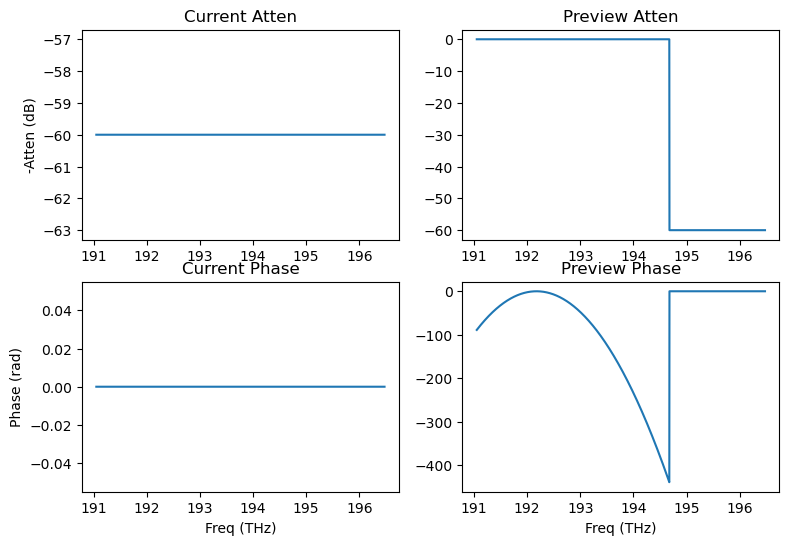

In [18]:
wsp.set3rdDisper(d2=-2.76,d3=0.)
wsp.setBandPass(span=5)
wsp.plotStatus()
wsp.writeProfile()

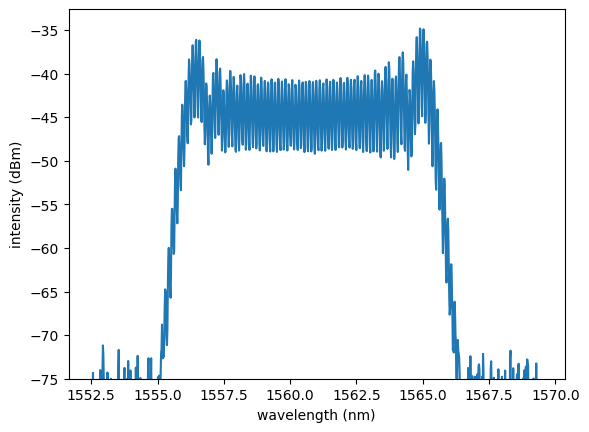

2024-04-17 12:39:37.856 | INFO     | Agilent 86142B | Agilent_86142B.py:get_trace:327
Agilent 86142B: Trace A data is collected and is shown in the plot.


(array([1552.5  , 1552.517, 1552.534, ..., 1569.466, 1569.483, 1569.5  ],
       dtype=float32),
 array([-76.5774 , -78.20536, -78.99807, ..., -78.9236 , -78.30168,
        -76.99837], dtype=float32))

In [67]:
osa.get_trace('a')

In [19]:
from KeckLFC.Hardware.SRS_SIM900 import SRS_SIM900, SRS_PIDcontrol_SIM960
srs = SRS_SIM900(addr='GPIB0::2::INSTR')
srs.connect()
servo_FC = SRS_PIDcontrol_SIM960(srs, 1, name='Filter Cavity PDH Lock Servo')
servo_IM = SRS_PIDcontrol_SIM960(srs, 3, name='Minicomb Intensity Lock Servo')
servo_RB = SRS_PIDcontrol_SIM960(srs, 5, name='Rio Laser Fceo Rb spectroscopy Lock Servo')


2024-07-21 13:30:10.256 | INFO     | Stanford Research System SIM900 | Device.py:connect:78
Stanford Research System SIM900 connected


In [47]:
servo_IM.printStatus()

2024-07-17 12:14:46.145 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:printStatus:201
--------------------------Minicomb Intensity Lock Servo--------------------------
|--------------------SRS PID controller SIM960 Status Summary--------------------
|----------------------------SIM960,s/n033669,ver2.17----------------------------
|	Output mode:	MAN,	Output limit: -3.000V TO 3.000V
|	Measured input:	 3.014446V
|	Amplified error:	 -1.579591V
|	Instant Output voltage:	 -0.001763V
|	Manual output set:	 0.0V
|	================ Set Point related================
|		Internal setpoint = 2.62 V, Ramping OFF
|		Setpoint input mode INT, Ext setpoint input 2.618668V
|		Setpoint RAMP speed = 0.01 V/s, action OFF
|	============= P,I,D and Offset Status=============
|		 P = 4.0    , 	action = ON
|		 I = 0.1 1/s, 	action = ON
|		 D = 1e-05   s, 	action = OFF
|		Off = 0.32  V, 	action = ON
-----------------SRS PID controller SIM960 Status Summary Ends------------------



'--------------------------Minicomb Intensity Lock Servo--------------------------\n|--------------------SRS PID controller SIM960 Status Summary--------------------\n|----------------------------SIM960,s/n033669,ver2.17----------------------------\n|\tOutput mode:\t\x1bMAN\x1b,\tOutput limit: -3.000V TO 3.000V\n|\tMeasured input:\t 3.014446V\n|\tAmplified error:\t -1.579591V\n|\tInstant Output voltage:\t -0.001763V\n|\tManual output set:\t 0.0V\n|\t================ Set Point related================\n|\t\tInternal setpoint = 2.62 V, Ramping \x1bOFF\x1b\n|\t\tSetpoint input mode INT, Ext setpoint input 2.618668V\n|\t\tSetpoint RAMP speed = 0.01 V/s, action \x1bOFF\x1b\n|\t============= P,I,D and Offset Status=============\n|\t\t P = 4.0    , \taction = \x1bON\x1b\n|\t\t I = 0.1 1/s, \taction = \x1bON\x1b\n|\t\t D = 1e-05   s, \taction = \x1bOFF\x1b\n|\t\tOff = 0.32  V, \taction = \x1bON\x1b\n-----------------SRS PID controller SIM960 Status Summary Ends------------------\n'

In [97]:
srs.disconnect()

2024-02-22 14:28:40.478 | INFO     | Stanford Research System SIM900 | Device.py:disconnect:90
Stanford Research System SIM900 disconnected


1

In [ ]:
from KeckLFC.Hardware.PritelAmp import PritelAmp

for i in range(3,23):
    try:
        ptamp = PritelAmp(addr=f"ASRL{i}::INSTR")
        ptamp.connect()
        ptamp.printStatus()

        print(f'com={i} success')
        
    except:
        # ptamp.disconnect()
        print(f'com={i} failed')

In [43]:
from KeckLFC.Hardware.PritelAmp import PritelAmp
ptamp = PritelAmp(addr=f'ASRL{7}::INSTR', name='Pritel Amp')
ptamp.connect()
ptamp.printStatus()


2024-07-21 14:03:28.668 | INFO     | Pritel Amp | PritelAmp.py:connect:60
Pritel Amp connected
2024-07-21 14:03:30.151 | INFO     | Pritel Amp | PritelAmp.py:printStatus:38
------------------------------------Pritel Amp-----------------------------------
|-----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary------------------
|	 Pump status: OFF
|	 InputPower = 0 mW, 	PreAmp = 0 mA
|	 OutputPower = 0.00 W, 	PwrAmp = 0.00 A
|	 AutoShutDown Enabled. PowerAmp pump current is disabled.
----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary Ends---------------



'------------------------------------Pritel Amp-----------------------------------\n|-----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary------------------\n|\t Pump status: \x1bOFF\x1b\n|\t InputPower = 0 mW, \tPreAmp = 0 mA\n|\t OutputPower = 0.00 W, \tPwrAmp = 0.00 A\n|\t AutoShutDown Enabled. PowerAmp pump current is disabled.\n----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary Ends---------------\n'

In [30]:
ptamp.preAmp=600

2024-07-21 13:31:59.784 | INFO     | Pritel Amp | PritelAmp.py:preAmp:115
Pritel Amp: Disable Ramping by self.ramp_pre_ma = 0, now 100 mA.
2024-07-21 13:32:00.574 | INFO     | Pritel Amp | PritelAmp.py:preAmp:121
Pritel Amp: Setting PreAmp Current to 000 mA, current Output 0.00 W.
2024-07-21 13:32:01.071 | INFO     | Pritel Amp | PritelAmp.py:preAmp:121
Pritel Amp: Setting PreAmp Current to 120 mA, current Output 0.00 W.
2024-07-21 13:32:01.567 | INFO     | Pritel Amp | PritelAmp.py:preAmp:121
Pritel Amp: Setting PreAmp Current to 240 mA, current Output 0.00 W.
2024-07-21 13:32:02.063 | INFO     | Pritel Amp | PritelAmp.py:preAmp:121
Pritel Amp: Setting PreAmp Current to 360 mA, current Output 0.00 W.
2024-07-21 13:32:02.559 | INFO     | Pritel Amp | PritelAmp.py:preAmp:121
Pritel Amp: Setting PreAmp Current to 480 mA, current Output 0.00 W.
2024-07-21 13:32:03.055 | INFO     | Pritel Amp | PritelAmp.py:preAmp:121
Pritel Amp: Setting PreAmp Current to 600 mA, current Output 0.00 W.


In [42]:
ptamp.activation=0

2024-07-21 14:03:20.887 | INFO     | Pritel Amp | PritelAmp.py:activation:203
Pritel Amp: ......waiting Activation status set to OFF, now ON
2024-07-21 14:03:21.559 | INFO     | Pritel Amp | PritelAmp.py:activation:206
Pritel Amp: setted Activation status as OFF, finished in 1.126 seconds


In [ ]:
ptamp.easy_turnOn()

In [41]:
ptamp.pwrAmp = '0A'

2024-07-21 13:58:09.346 | INFO     | Pritel Amp | PritelAmp.py:pwrAmp:151
Pritel Amp: Disable Ramping by self.ramp_pwr_ma = 0, now 50 mA.
2024-07-21 13:58:10.214 | INFO     | Pritel Amp | PritelAmp.py:pwrAmp:157
Pritel Amp: Setting PowerAmp Current to 1.51 A, current Output 1.23 W.
2024-07-21 13:58:10.870 | INFO     | Pritel Amp | PritelAmp.py:pwrAmp:157
Pritel Amp: Setting PowerAmp Current to 1.46 A, current Output 1.11 W.
2024-07-21 13:58:11.510 | INFO     | Pritel Amp | PritelAmp.py:pwrAmp:157
Pritel Amp: Setting PowerAmp Current to 1.41 A, current Output 1.06 W.
2024-07-21 13:58:12.161 | INFO     | Pritel Amp | PritelAmp.py:pwrAmp:157
Pritel Amp: Setting PowerAmp Current to 1.36 A, current Output 1.00 W.
2024-07-21 13:58:12.818 | INFO     | Pritel Amp | PritelAmp.py:pwrAmp:157
Pritel Amp: Setting PowerAmp Current to 1.31 A, current Output 0.93 W.
2024-07-21 13:58:13.474 | INFO     | Pritel Amp | PritelAmp.py:pwrAmp:157
Pritel Amp: Setting PowerAmp Current to 1.26 A, current Output 

In [107]:
ptamp.printStatus()

2024-07-20 13:20:08.535 | INFO     | Pritel Amp | PritelAmp.py:printStatus:38
------------------------------------Pritel Amp-----------------------------------
|-----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary------------------
|	 Pump status: ON
|	 InputPower = 138 mW, 	PreAmp = 603 mA
|	 OutputPower = 0.00 W, 	PwrAmp = 0.00 A
|	 AutoShutDown Disabled.
----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary Ends---------------



'------------------------------------Pritel Amp-----------------------------------\n|-----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary------------------\n|\t Pump status: \x1bON\x1b\n|\t InputPower = 138 mW, \tPreAmp = 603 mA\n|\t OutputPower = 0.00 W, \tPwrAmp = 0.00 A\n|\t AutoShutDown Disabled.\n----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary Ends---------------\n'

In [36]:
ptamp.printStatus()

2024-07-20 10:34:23.606 | INFO     | Pritel Amp | PritelAmp.py:printStatus:38
------------------------------------Pritel Amp-----------------------------------
|-----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary------------------
|	 Pump status: ON
|	 InputPower = 140 mW, 	PreAmp = 603 mA
|	 OutputPower = 0.00 W, 	PwrAmp = 0.00 A
|	 AutoShutDown Disabled.
----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary Ends---------------



'------------------------------------Pritel Amp-----------------------------------\n|-----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary------------------\n|\t Pump status: \x1bON\x1b\n|\t InputPower = 140 mW, \tPreAmp = 603 mA\n|\t OutputPower = 0.00 W, \tPwrAmp = 0.00 A\n|\t AutoShutDown Disabled.\n----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary Ends---------------\n'

In [160]:
# ptamp.preAmp = '600mA'
# ptamp.pwrAmp = '0A'

ptamp.activation = 0

2024-04-17 14:19:44.189 | INFO     | Pritel Amp | PritelAmp.py:activation:203
Pritel Amp: ......waiting Activation status set to OFF, now ON
2024-04-17 14:19:44.861 | INFO     | Pritel Amp | PritelAmp.py:activation:206
Pritel Amp: setted Activation status as OFF, finished in 1.123 seconds


In [80]:
from KeckLFC.Hardware.AmonicsEDFA import AmonicsEDFA
amonic13 = AmonicsEDFA(addr=f'ASRL{9}::INSTR', name='Amonics EDFA 13 dBm')
amonic13.connect()
amonic13.printStatus()

2024-02-22 14:20:40.162 | INFO     | Amonics EDFA 13 dBm | Device.py:connect:78
Amonics EDFA 13 dBm connected
2024-02-22 14:20:46.424 | INFO     | Amonics EDFA 13 dBm | AmonicsEDFA.py:printStatus:49
-------------------------------Amonics EDFA 13 dBm-------------------------------
|--------------------------Amonics EDFA Status Summary---------------------------
|------------------Model: AEDFA-PM-13-R-FA, Serial No.22020701-------------------
|	InterLock Status: UNLOCKED
|	Case Temperature: 27.31°C
|	Master Activation: OFF
|	------------Channel Summary-------------
|	 CHANNEL1: 
|		 Mode: ACC
|		 Set Cur: 0.0 mA
|		 Status: OFF
|		 Input Power: 0.0 mW
|		 Output Power: 0.0 mW
|		 Internal PD Power: 0.0 mW
------------------------Amonics EDFA Status Summary Ends------------------------



'-------------------------------Amonics EDFA 13 dBm-------------------------------\n|--------------------------Amonics EDFA Status Summary---------------------------\n|------------------Model: AEDFA-PM-13-R-FA, Serial No.22020701-------------------\n|\tInterLock Status: \x1bUNLOCKED\x1b\n|\tCase Temperature: 27.31°C\n|\tMaster Activation: \x1bOFF\x1b\n|\t------------Channel Summary-------------\n|\t CHANNEL1: \n|\t\t Mode: ACC\n|\t\t Set Cur: 0.0 mA\n|\t\t Status: \x1bOFF\x1b\n|\t\t Input Power: 0.0 mW\n|\t\t Output Power: 0.0 mW\n|\t\t Internal PD Power: 0.0 mW\n------------------------Amonics EDFA Status Summary Ends------------------------\n'

In [57]:
from KeckLFC.Hardware.Agiltron_2by2_switch import AgiltronSelfAlign22
sw2 = AgiltronSelfAlign22(addr=f'COM{20}')
sw2.connect()
sw2.check_status()

2024-07-20 11:32:34.619 | INFO     | Agiltron 2 by 2 switch | Device.py:connect:78
Agiltron 2 by 2 switch connected


2

In [67]:
sw2.set_status(2)

2024-07-20 11:36:03.068 | INFO     | Agiltron 2 by 2 switch | Agiltron_2by2_switch.py:set_status:113
status set to 2


In [58]:
sw2.check_status()

2

In [297]:
sw2.disconnect()

2024-07-19 17:36:13.797 | INFO     | Agiltron 2 by 2 switch | Device.py:disconnect:90
Agiltron 2 by 2 switch disconnected


1

In [ ]:
################ locking all 2024-04-08

In [22]:
from KeckLFC.Hardware.SRS_SIM900 import SRS_SIM900, SRS_PIDcontrol_SIM960
srs = SRS_SIM900(addr='GPIB0::2::INSTR')
srs.connect()
servo_FC = SRS_PIDcontrol_SIM960(srs, 1, name='Filter Cavity PDH Lock Servo')
servo_IM = SRS_PIDcontrol_SIM960(srs, 3, name='Minicomb Intensity Lock Servo')
servo_RB = SRS_PIDcontrol_SIM960(srs, 5, name='Rio Laser Fceo Rb spectroscopy Lock Servo')

from KeckLFC.Hardware.TDS2024C import TDS2024C
osc = TDS2024C()
osc.connect()

from KeckLFC.Hardware.KeysightFG_33500 import KeysightFG_33500
fg = KeysightFG_33500(addr='USB0::0x0957::0x2807::MY59003824::INSTR', name='Keysight FG 33500')
fg.connect()

2024-07-18 10:18:25.382 | INFO     | Stanford Research System SIM900 | Device.py:connect:78
Stanford Research System SIM900 connected
2024-07-18 10:18:36.240 | INFO     | TDS2024C OSC | Device.py:connect:78
TDS2024C OSC connected
2024-07-18 10:18:36.763 | INFO     | Keysight FG 33500 | Device.py:connect:78
Keysight FG 33500 connected


1

In [17]:
from KeckLFC.Hardware.KeysightFG_33500 import KeysightFG_33500
fg = KeysightFG_33500(addr='USB0::0x0957::0x2807::MY59003824::INSTR', name='Keysight FG 33500')
fg.connect()

2024-07-03 12:40:22.016 | INFO     | Keysight FG 33500 | Device.py:connect:78
Keysight FG 33500 connected


1

In [65]:
servo_IM.output_upperlim = 3
servo_IM.output_lowerlim = -3
servo_IM.printStatus()


2024-04-17 11:23:47.954 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:__set_num_withcmd:812
Minicomb Intensity Lock Servo: Setting Output Upper limit in Volt to 3.0.
2024-04-17 11:23:48.168 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:__set_num_withcmd:812
Minicomb Intensity Lock Servo: Setting Output Lower limit in Volt to -3.0.
2024-04-17 11:23:53.230 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:printStatus:201
--------------------------Minicomb Intensity Lock Servo--------------------------
|--------------------SRS PID controller SIM960 Status Summary--------------------
|----------------------------SIM960,s/n033669,ver2.17----------------------------
|	Output mode:	PID,	Output limit: -3.000V TO 3.000V
|	Measured input:	 3.783233V
|	Amplified error:	 -0.013235V
|	Instant Output voltage:	 0.165126V
|	Manual output set:	 0.32V
|	================ Set Point related================
|		Internal setpoint = 3.78 V, Ramping OFF
|		Setpoint input mode 

'--------------------------Minicomb Intensity Lock Servo--------------------------\n|--------------------SRS PID controller SIM960 Status Summary--------------------\n|----------------------------SIM960,s/n033669,ver2.17----------------------------\n|\tOutput mode:\t\x1bPID\x1b,\tOutput limit: -3.000V TO 3.000V\n|\tMeasured input:\t 3.783233V\n|\tAmplified error:\t -0.013235V\n|\tInstant Output voltage:\t 0.165126V\n|\tManual output set:\t 0.32V\n|\t================ Set Point related================\n|\t\tInternal setpoint = 3.78 V, Ramping \x1bOFF\x1b\n|\t\tSetpoint input mode INT, Ext setpoint input 3.778188V\n|\t\tSetpoint RAMP speed = 0.01 V/s, action \x1bOFF\x1b\n|\t============= P,I,D and Offset Status=============\n|\t\t P = 4.0    , \taction = \x1bON\x1b\n|\t\t I = 0.1 1/s, \taction = \x1bON\x1b\n|\t\t D = 1e-05   s, \taction = \x1bOFF\x1b\n|\t\tOff = 0.32  V, \taction = \x1bON\x1b\n-----------------SRS PID controller SIM960 Status Summary Ends------------------\n'

2024-04-16 12:30:31.782 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:666
Minicomb Intensity Lock Servo: ....Manual output voltage Ramping.... Disable ranp by set self.manual_output_ramp=0. 
2024-04-16 12:30:31.988 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:671
Minicomb Intensity Lock Servo: Output in Manual Mode in Volt set to 0.320.
2024-04-16 12:30:32.198 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:671
Minicomb Intensity Lock Servo: Output in Manual Mode in Volt set to 0.219.
2024-04-16 12:30:32.405 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:671
Minicomb Intensity Lock Servo: Output in Manual Mode in Volt set to 0.118.
2024-04-16 12:30:32.608 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:671
Minicomb Intensity Lock Servo: Output in Manual Mode in Volt set to 0.017.
2024-04-16 12:30:32.821 | INFO     | Minicomb Intensity Lo

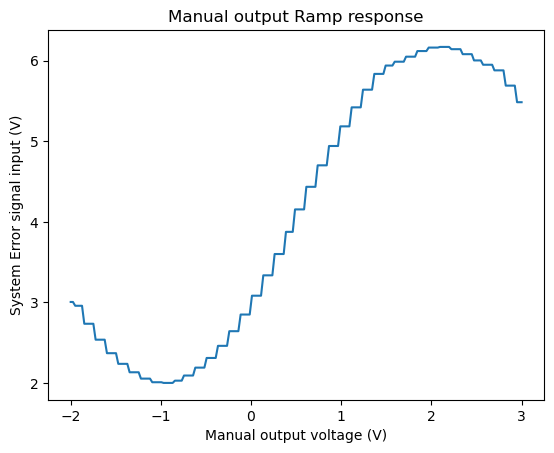

2024-04-16 12:31:03.956 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:666
Minicomb Intensity Lock Servo: ....Manual output voltage Ramping.... Disable ranp by set self.manual_output_ramp=0. 
2024-04-16 12:31:04.166 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:671
Minicomb Intensity Lock Servo: Output in Manual Mode in Volt set to 3.000.
2024-04-16 12:31:04.374 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:671
Minicomb Intensity Lock Servo: Output in Manual Mode in Volt set to 2.897.
2024-04-16 12:31:04.583 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:671
Minicomb Intensity Lock Servo: Output in Manual Mode in Volt set to 2.794.
2024-04-16 12:31:04.793 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:671
Minicomb Intensity Lock Servo: Output in Manual Mode in Volt set to 2.691.
2024-04-16 12:31:05.000 | INFO     | Minicomb Intensity Lo

In [48]:
import numpy as np
scan_start = -2
scan_stop =3
num_steps= 200

servo_IM.manual_output_ramp=0.1
servo_IM.manual_output = scan_start

r = servo_IM.manual_sweep(np.linspace(scan_start,scan_stop,num_steps))

servo_IM.manual_output=0.32

In [534]:
servo_IM = SRS_PIDcontrol_SIM960(srs, 3, name='Minicomb Intensity Lock Servo')

In [55]:
servo_IM.prop_gain=4  #-2
servo_IM.intg_gain=0.1   #1
servo_IM.outoffset=0.32
servo_IM.set_setpoint(3.78)

2024-04-16 12:33:16.457 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:__set_num_withcmd:812
Minicomb Intensity Lock Servo: Setting Proportional Gain in V/V to 4.0.
2024-04-16 12:33:16.673 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:__set_num_withcmd:812
Minicomb Intensity Lock Servo: Setting Integral Gain in 1/seconds to 0.1.
2024-04-16 12:33:16.882 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:__set_num_withcmd:812
Minicomb Intensity Lock Servo: Setting Output offset in Volts to 0.32.
2024-04-16 12:33:17.089 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:__set_num_withcmd:812
Minicomb Intensity Lock Servo: Setting Locking set point in Volt to 3.78.


In [51]:
servo_IM.output_mode = 'pid'  #'man'  or 'pid'

2024-04-16 12:32:29.061 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_output_mode:534
Minicomb Intensity Lock Servo: PID output is turned ON.


In [66]:
servo_IM.printStatus()

2024-04-17 12:39:09.203 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:printStatus:201
--------------------------Minicomb Intensity Lock Servo--------------------------
|--------------------SRS PID controller SIM960 Status Summary--------------------
|----------------------------SIM960,s/n033669,ver2.17----------------------------
|	Output mode:	PID,	Output limit: -3.000V TO 3.000V
|	Measured input:	 3.783758V
|	Amplified error:	 -0.015279V
|	Instant Output voltage:	 0.161829V
|	Manual output set:	 0.32V
|	================ Set Point related================
|		Internal setpoint = 3.78 V, Ramping OFF
|		Setpoint input mode INT, Ext setpoint input 3.778178V
|		Setpoint RAMP speed = 0.01 V/s, action OFF
|	============= P,I,D and Offset Status=============
|		 P = 4.0    , 	action = ON
|		 I = 0.1 1/s, 	action = ON
|		 D = 1e-05   s, 	action = OFF
|		Off = 0.32  V, 	action = ON
-----------------SRS PID controller SIM960 Status Summary Ends------------------



'--------------------------Minicomb Intensity Lock Servo--------------------------\n|--------------------SRS PID controller SIM960 Status Summary--------------------\n|----------------------------SIM960,s/n033669,ver2.17----------------------------\n|\tOutput mode:\t\x1bPID\x1b,\tOutput limit: -3.000V TO 3.000V\n|\tMeasured input:\t 3.783758V\n|\tAmplified error:\t -0.015279V\n|\tInstant Output voltage:\t 0.161829V\n|\tManual output set:\t 0.32V\n|\t================ Set Point related================\n|\t\tInternal setpoint = 3.78 V, Ramping \x1bOFF\x1b\n|\t\tSetpoint input mode INT, Ext setpoint input 3.778178V\n|\t\tSetpoint RAMP speed = 0.01 V/s, action \x1bOFF\x1b\n|\t============= P,I,D and Offset Status=============\n|\t\t P = 4.0    , \taction = \x1bON\x1b\n|\t\t I = 0.1 1/s, \taction = \x1bON\x1b\n|\t\t D = 1e-05   s, \taction = \x1bOFF\x1b\n|\t\tOff = 0.32  V, \taction = \x1bON\x1b\n-----------------SRS PID controller SIM960 Status Summary Ends------------------\n'

In [62]:
# servo_IM.output_mode = 'man'  #'man'  or 'pid'
# servo_IM.output_mode = 'pid'  #'man'  or 'pid'
import time
for i in range(10):

    print(servo_IM.get_output_voltage() ) 
    time.sleep(0.5)

0.307418
0.307296
0.307144
0.307148
0.307009
0.30698
0.30698
0.306806
0.306723
0.306608


In [33]:
from KeckLFC.Hardware.hk_shutter import hk_shutter
hks = hk_shutter(addr='COM17')   #5,8,11,14,17
hks.connect()

2024-07-20 10:30:57.886 | INFO     | hk_shutter | hk_shutter.py:connect:31
hk_shutter connected


1

In [115]:
hks.get_status()

Shutter is 1


1

In [83]:
hks.get_mode()

Shutter is in Manual mode


1

In [117]:
hks.set_status(1)

Shutter is 0
Shutter is 1
Shutter is set to 1


1

In [291]:
hks.disconnect()

2024-07-19 17:24:33.955 | INFO     | hk_shutter | hk_shutter.py:disconnect:44
hk_shutter disconnected


1

In [278]:
arduino.shut_YJ()

'YJShut\r\r\nYJ shutter is UP, YJ is shutted.'

In [19]:
from KeckLFC.Hardware.TDS2024C import TDS2024C
osc = TDS2024C()
osc.connect()

2024-07-03 12:41:53.437 | INFO     | TDS2024C OSC | Device.py:connect:78
TDS2024C OSC connected


1

In [ ]:
osc.get_trace(trace=4)

In [ ]:
osc.query('CH1:VOL 2')

In [22]:
osc.write("ACQuire:STATE RUN")

In [25]:
osc.query('CH1:SCA?')

'2.0E0'

In [277]:
a=1
osc.write(f'CH{a}:SCA 3')

In [331]:
osc.query('HOR:SCA?')

'1.0E-1'

In [281]:
osc.write('HOR:POS 1')

In [308]:
osc.write('TRIG:MAI:EDGE:SOU EXT')

In [26]:
osc.query('TRIG:MAI:EDGE:SOU?')

'EXT'

In [307]:
osc.query('TRIG:MAI:LEV?')

'2.0E-1'

In [328]:
osc.query('CH1:POS?')

'3.0E0'

In [327]:
osc.write('CH1:POS 3')

In [27]:
osc.query('SEL?')

'1;1;0;0;0;0;0;0;0'

In [347]:
osc.write('SEL:CH4 ON')

In [364]:

def set_vol_pos(self,channle,pos):

    self.write(f'CH{channle}:POS {pos}')
    print(f'CH{channle} set to '+ self.query(f'CH{channle}:POS?'))
    #return self.query(f'CH{channle}:POS?')

def set_vol_scale(self,channle,sca):

    self.write(f'CH{channle}:SCA {sca}')
    print(f'CH{channle} set to '+self.query(f'CH{channle}:SCA?'))
    #return self.query(f'CH{channle}:SCA?')

def set_time_pos(self,pos):
    self.write(f'HOR:POS {pos}')
    print(f'time pos set to '+self.query(f'HOR:POS?'))

def set_time_scale(self,sca):

    self.write(f'HOR:SCA {sca}')
    print(f'time scale set to '+self.query(f'HOR:SCA?'))

def trace_disp(self,chan,state):

    if (state == 1) or( state=='ON'):
        self.write(f'SEL:CH{chan} ON')
    if (state == 0) or(state== 'OFF'):
        self.write(f'SEL:CH{chan} OFF')
    print(f'display set to '+self.query('SEL?'))

def set_trigger_source(self,chan):

    self.write(f'TRIG:MAI:EDGE:SOU {chan}')
    print(f'trigger souce set to '+self.query(f'TRIG:MAI:EDGE:SOU?'))

def set_trigger_lev(self,lvl):
    self.write(f'TRIG:MAI:LEV {lvl}')
    print(f'trigger level set to '+self.query('TRIG:MAI:LEV?'))

In [395]:
set_time_pos(osc,0)

time pos set to 0.0E0


In [402]:
set_trigger_lev(osc, 2)

trigger level set to 2.0E0


In [394]:
set_trigger_source(osc,'CH4')

trigger souce set to CH4


In [440]:
set_vol_pos(osc, 1, -1.5)


CH1 set to -1.48E0


'-1.48E0'

In [443]:
set_vol_scale(osc,2,0.01)

CH2 set to 1.0E-2


'1.0E-2'

In [431]:
set_vol_scale(osc,1,0.03)

set_vol_scale(osc,2,0.03)

set_vol_scale(osc,3,0.03)


CH1 set to 3.0E-2
CH2 set to 3.0E-2
CH3 set to 3.0E-2


'3.0E-2'

In [375]:
set_trigger_lev(osc,0.2)

trigger level set to 2.0E-1


In [424]:
set_time_scale(osc,0.05)

time scale set to 5.0E-2


In [433]:
trace_disp(self=osc,chan=3,state=1)
# chan=1
# osc.write(f'SEL:CH{chan} ON')

display set to 1;1;1;1;0;0;0;0;0


2024-04-12 14:00:50.429 | INFO     | TDS2024C OSC | TDS2024C.py:get_trace:134
TDS2024C OSC: Trace 2 data read finished.


{'BYT_Nr': 2,
 'BIT_Nr': 16,
 'ENCd': 'ASC',
 'BN_Fmt': 'RP',
 'BYT_Or': 'MSB',
 'NR_Pt': 2500,
 'WFID': '"Ch2, DC coupling, 3.0E-2 V/div, 5.0E-2 s/div, 2500 points, Sample mode"',
 'PT_FMT': 'Y',
 'XINcr': 0.0002,
 'PT_Off': 0.0,
 'XZEro': -0.25,
 'XUNit': '"s"',
 'YMUlt': 4.6875e-06,
 'YZEro': 0.0,
 'YOFF': -1792.0,
 'YUNit': '"Volts"',
 'Y': array([0.0036, 0.006 , 0.0012, ..., 0.0012, 0.0024, 0.0024]),
 'X': array([-0.25  , -0.2498, -0.2496, ...,  0.2494,  0.2496,  0.2498])}

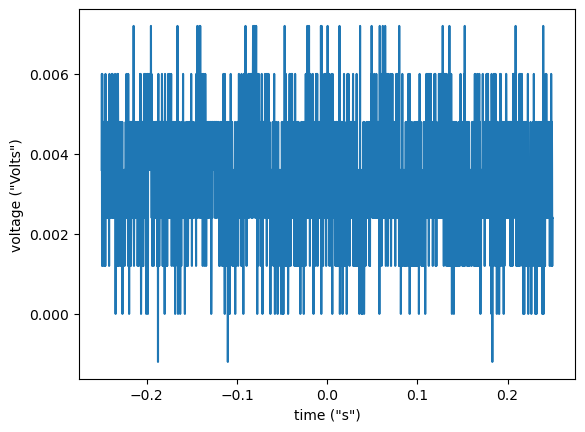

In [435]:
osc.get_trace(2)

In [6]:
from KeckLFC.Hardware import autolock
import time
import matplotlib.pyplot as plt
autolock = autolock.AutoRbLock(osc, fg, servo_RB)

In [303]:
fg.set_trigger_source(1)

trig source=CH1



In [334]:
servo_RB.output_voltage

0.01515

In [412]:
fg.set_trigger_type(1, 'IMM')

In [413]:
fg.query("TRIG1:SOUR?")

'IMM\n'

In [419]:
fg.get_channel_amplitude(1)
fg.get_channel_parameters(1)

Channel 1 parameters:
Frequency: 10.0
Amplitude: 8.0
Offset: 0.0
Phase: 0.0
State: 1

Function: RAMP



In [420]:
fg.get_channel_state(1)

'1\n'

In [422]:
servo_RB.printStatus()

2024-04-12 13:45:21.732 | INFO     | Rio Laser Fceo Rb spectroscopy Lock Servo | SRS_SIM900.py:printStatus:201
--------------------Rio Laser Fceo Rb spectroscopy Lock Servo--------------------
|--------------------SRS PID controller SIM960 Status Summary--------------------
|----------------------------SIM960,s/n033683,ver2.17----------------------------
|	Output mode:	MAN,	Output limit: -4.000V TO 4.000V
|	Measured input:	 0.002018V
|	Amplified error:	 -0.007743V
|	Instant Output voltage:	 -0.005581V
|	Manual output set:	 0.0V
|	================ Set Point related================
|		Internal setpoint = -0.01 V, Ramping OFF
|		Setpoint input mode INT, Ext setpoint input -0.009426V
|		Setpoint RAMP speed = 0.01 V/s, action OFF
|	============= P,I,D and Offset Status=============
|		 P = 0.7    , 	action = ON
|		 I = 1500.0 1/s, 	action = ON
|		 D = 6e-05   s, 	action = OFF
|		Off = 0.0  V, 	action = ON
-----------------SRS PID controller SIM960 Status Summary Ends------------------



'--------------------Rio Laser Fceo Rb spectroscopy Lock Servo--------------------\n|--------------------SRS PID controller SIM960 Status Summary--------------------\n|----------------------------SIM960,s/n033683,ver2.17----------------------------\n|\tOutput mode:\t\x1bMAN\x1b,\tOutput limit: -4.000V TO 4.000V\n|\tMeasured input:\t 0.002018V\n|\tAmplified error:\t -0.007743V\n|\tInstant Output voltage:\t -0.005581V\n|\tManual output set:\t 0.0V\n|\t================ Set Point related================\n|\t\tInternal setpoint = -0.01 V, Ramping \x1bOFF\x1b\n|\t\tSetpoint input mode INT, Ext setpoint input -0.009426V\n|\t\tSetpoint RAMP speed = 0.01 V/s, action \x1bOFF\x1b\n|\t============= P,I,D and Offset Status=============\n|\t\t P = 0.7    , \taction = \x1bON\x1b\n|\t\t I = 1500.0 1/s, \taction = \x1bON\x1b\n|\t\t D = 6e-05   s, \taction = \x1bOFF\x1b\n|\t\tOff = 0.0  V, \taction = \x1bON\x1b\n-----------------SRS PID controller SIM960 Status Summary Ends------------------\n'

In [425]:
servo_RB.output_mode='man'
fg.set_channel_parameters(channel=1, freq=20, amp=4, offset=0, phase=0)
fg.set_channel_func(1, 'ramp')
fg.set_channel_state(1, 1)
# time.sleep(10)
# trace_x,trace_y=autolock.get_trace(trace = 1)
# plt.plot(trace_x,trace_y)

2024-04-12 13:52:12.512 | INFO     | Rio Laser Fceo Rb spectroscopy Lock Servo | SRS_SIM900.py:set_output_mode:537
Rio Laser Fceo Rb spectroscopy Lock Servo: PID output is turned OFF, output mode is turnd to Manual.


Channel 1 parameters:
Frequency: 20.0
Amplitude: 4.0
Offset: 0.0
Phase: 0.0
State: 1

Function: RAMP

RAMP



2024-04-10 08:50:34.044 | INFO     | TDS2024C OSC | TDS2024C.py:get_trace:134
TDS2024C OSC: Trace 4 data read finished.


{'BYT_Nr': 2,
 'BIT_Nr': 16,
 'ENCd': 'ASC',
 'BN_Fmt': 'RP',
 'BYT_Or': 'MSB',
 'NR_Pt': 2500,
 'WFID': '"Ch4, DC coupling, 5.0E0 V/div, 5.0E-4 s/div, 2500 points, Sample mode"',
 'PT_FMT': 'Y',
 'XINcr': 2e-06,
 'PT_Off': 0.0,
 'XZEro': -0.0025,
 'XUNit': '"s"',
 'YMUlt': 0.00078125,
 'YZEro': 0.0,
 'YOFF': -12800.0,
 'YUNit': '"Volts"',
 'Y': array([12., 12., 12., ..., 12., 12., 12.]),
 'X': array([-0.0025  , -0.002498, -0.002496, ...,  0.002494,  0.002496,
         0.002498])}

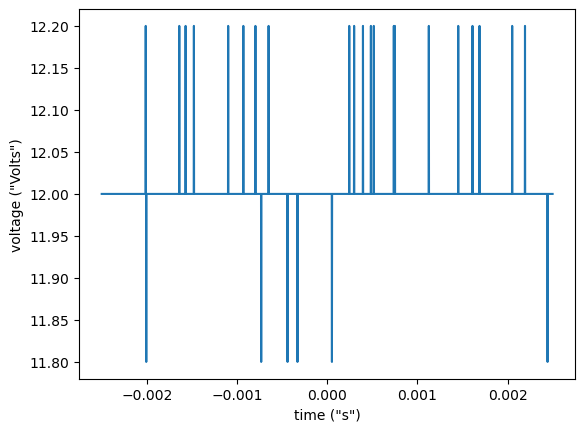

In [11]:
osc.get_trace(trace=4)

In [60]:
from KeckLFC.Hardware.OZopticsVOA import OZopticsVOA
voa1550 = OZopticsVOA(addr=f'ASRL{15}::INSTR', name='1.55um VOA')
voa1550.connect()
voa1550.printStatus()

2024-07-20 11:33:30.462 | INFO     | 1.55um VOA | Device.py:connect:78
1.55um VOA connected
2024-07-20 11:33:31.045 | INFO     | 1.55um VOA | OZopticsVOA.py:printStatus:44
-----------------------------------1.55um VOA-----------------------------------
--------------------------OZ optics VOA Status Summary--------------------------
|	 Attenuation: 0.00 (dB)
|	 Device Configure String:
|		DD100MC 
|		V6.4
|		NO:303700-01
|		MAX ATTEN:61.00
|		OVERSHOOT:-30
|		CALIB:FEB-22-2022
|		GEAR RATIO:485:1
|		MOTOR VOLT:5V
|		MINTERVAL(MS):0.90
|		IL:0.00
|		WAVELENGTH:1550
|		I2C ADDRESS:64
|		W0 1550
-----------------------OZ optics VOA Status Summary Ends------------------------



'-----------------------------------1.55um VOA-----------------------------------\n--------------------------OZ optics VOA Status Summary--------------------------\n|\t Attenuation: 0.00 (dB)\n|\t Device Configure String:\n|\t\tDD100MC \n|\t\tV6.4\n|\t\tNO:303700-01\n|\t\tMAX ATTEN:61.00\n|\t\tOVERSHOOT:-30\n|\t\tCALIB:FEB-22-2022\n|\t\tGEAR RATIO:485:1\n|\t\tMOTOR VOLT:5V\n|\t\tMINTERVAL(MS):0.90\n|\t\tIL:0.00\n|\t\tWAVELENGTH:1550\n|\t\tI2C ADDRESS:64\n|\t\tW0 1550\n-----------------------OZ optics VOA Status Summary Ends------------------------\n'

In [219]:
voa1550.printStatus()

2024-04-10 14:49:34.570 | INFO     | 1.55um VOA | OZopticsVOA.py:printStatus:44
-----------------------------------1.55um VOA-----------------------------------
--------------------------OZ optics VOA Status Summary--------------------------
|	 Attenuation: 20.00 (dB)
|	 Device Configure String:
|		DD100MC 
|		V6.4
|		NO:303700-01
|		MAX ATTEN:61.00
|		OVERSHOOT:-30
|		CALIB:FEB-22-2022
|		GEAR RATIO:485:1
|		MOTOR VOLT:5V
|		MINTERVAL(MS):0.90
|		IL:0.00
|		WAVELENGTH:1550
|		I2C ADDRESS:64
|		W0 1550
-----------------------OZ optics VOA Status Summary Ends------------------------



'-----------------------------------1.55um VOA-----------------------------------\n--------------------------OZ optics VOA Status Summary--------------------------\n|\t Attenuation: 20.00 (dB)\n|\t Device Configure String:\n|\t\tDD100MC \n|\t\tV6.4\n|\t\tNO:303700-01\n|\t\tMAX ATTEN:61.00\n|\t\tOVERSHOOT:-30\n|\t\tCALIB:FEB-22-2022\n|\t\tGEAR RATIO:485:1\n|\t\tMOTOR VOLT:5V\n|\t\tMINTERVAL(MS):0.90\n|\t\tIL:0.00\n|\t\tWAVELENGTH:1550\n|\t\tI2C ADDRESS:64\n|\t\tW0 1550\n-----------------------OZ optics VOA Status Summary Ends------------------------\n'

In [106]:
voa1550.atten_db=0  #34

VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

In [123]:
voa2000.atten_db=0

2024-04-17 13:12:56.396 | INFO     | 2um VOA | OZopticsVOA.py:_setAttenStr:61
2um VOA: VOA attenuation setted to 0.00 dB.


In [294]:
voa1550.disconnect()
voa1310.disconnect()
voa2000.disconnect()

2024-07-19 17:32:02.168 | INFO     | 1.55um VOA | Device.py:disconnect:90
1.55um VOA disconnected
2024-07-19 17:32:02.222 | INFO     | 1um VOA | Device.py:disconnect:90
1um VOA disconnected
2024-07-19 17:32:02.269 | INFO     | 2um VOA | Device.py:disconnect:90
2um VOA disconnected


1

2024-04-17 13:42:54.402 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set3rdDisper:90
Waveshaper Set 3rd disper with d2=-2.71 ps/nm, d3=0.0 ps/nm^2, center 192.17465256410256 THz.
2024-04-17 13:42:54.408 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:setBandPass:127
Waveshaper Set atten to BandPass [189.675~194.675] THz ([1580.559~1539.964] nm).
2024-04-17 13:42:55.826 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:226
Waveshaper profile write successful.


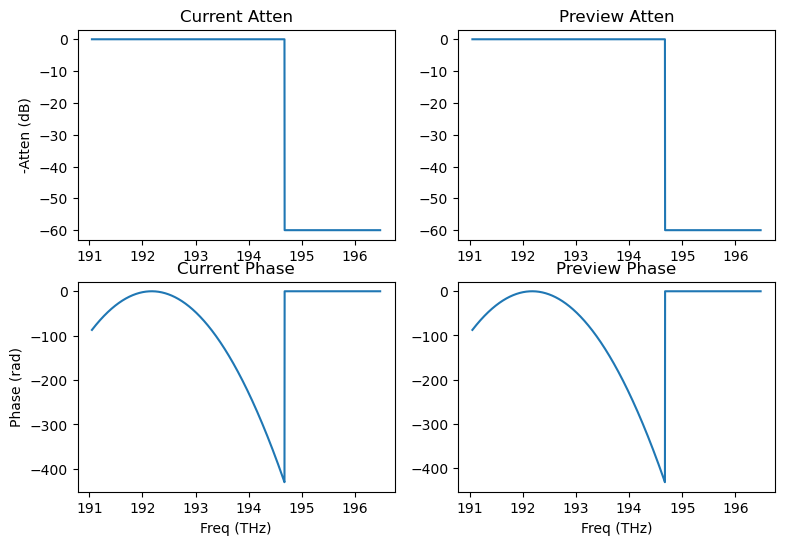

In [152]:
wsp.set3rdDisper(d2=-2.71,d3=0.)
wsp.setBandPass(span=5)
wsp.plotStatus()
wsp.writeProfile()

In [187]:
voa2000.printStatus()

2024-04-10 14:27:38.528 | INFO     | 2um VOA | OZopticsVOA.py:printStatus:44
------------------------------------2um VOA-------------------------------------
--------------------------OZ optics VOA Status Summary--------------------------
|	 Attenuation: 10.00 (dB)
|	 Device Configure String:
|		DD100MC
|		V6.2a
|		NO:303699-01
|		MAX ATTEN:55.00
|		OVERSHOOT:-30
|		CALIB:MAR-02-2022
|		GEAR RATIO:485:1
|		MINTERVAL(MS):0.90
|		MOTOR VOLT:5
|		IL:0.00
|		WAVELENGTH:2000
|		I2C ADDRESS:64
|		W0 2000
-----------------------OZ optics VOA Status Summary Ends------------------------



'------------------------------------2um VOA-------------------------------------\n--------------------------OZ optics VOA Status Summary--------------------------\n|\t Attenuation: 10.00 (dB)\n|\t Device Configure String:\n|\t\tDD100MC\n|\t\tV6.2a\n|\t\tNO:303699-01\n|\t\tMAX ATTEN:55.00\n|\t\tOVERSHOOT:-30\n|\t\tCALIB:MAR-02-2022\n|\t\tGEAR RATIO:485:1\n|\t\tMINTERVAL(MS):0.90\n|\t\tMOTOR VOLT:5\n|\t\tIL:0.00\n|\t\tWAVELENGTH:2000\n|\t\tI2C ADDRESS:64\n|\t\tW0 2000\n-----------------------OZ optics VOA Status Summary Ends------------------------\n'

In [148]:
voa1550.atten_db=32

2024-04-17 13:37:49.529 | INFO     | 1.55um VOA | OZopticsVOA.py:_setAttenStr:61
1.55um VOA: VOA attenuation setted to 32.00 dB.


In [256]:
voa2000.atten_db

0.0

In [ ]:
voa1310

In [61]:
from KeckLFC.Hardware.OZopticsVOA import OZopticsVOA
voa2000 = OZopticsVOA(addr=f'ASRL{18}::INSTR', name='2um VOA')
voa2000.connect()
voa2000.printStatus()

2024-07-20 11:33:47.421 | INFO     | 2um VOA | Device.py:connect:78
2um VOA connected
2024-07-20 11:33:48.026 | INFO     | 2um VOA | OZopticsVOA.py:printStatus:44
------------------------------------2um VOA-------------------------------------
--------------------------OZ optics VOA Status Summary--------------------------
|	 Attenuation: 0.00 (dB)
|	 Device Configure String:
|		DD100MC
|		V6.2a
|		NO:303699-01
|		MAX ATTEN:55.00
|		OVERSHOOT:-30
|		CALIB:MAR-02-2022
|		GEAR RATIO:485:1
|		MINTERVAL(MS):0.90
|		MOTOR VOLT:5
|		IL:0.00
|		WAVELENGTH:2000
|		I2C ADDRESS:64
|		W0 2000
-----------------------OZ optics VOA Status Summary Ends------------------------



'------------------------------------2um VOA-------------------------------------\n--------------------------OZ optics VOA Status Summary--------------------------\n|\t Attenuation: 0.00 (dB)\n|\t Device Configure String:\n|\t\tDD100MC\n|\t\tV6.2a\n|\t\tNO:303699-01\n|\t\tMAX ATTEN:55.00\n|\t\tOVERSHOOT:-30\n|\t\tCALIB:MAR-02-2022\n|\t\tGEAR RATIO:485:1\n|\t\tMINTERVAL(MS):0.90\n|\t\tMOTOR VOLT:5\n|\t\tIL:0.00\n|\t\tWAVELENGTH:2000\n|\t\tI2C ADDRESS:64\n|\t\tW0 2000\n-----------------------OZ optics VOA Status Summary Ends------------------------\n'

In [95]:
voa2000.atten_db=20

2024-04-17 12:53:59.527 | INFO     | 2um VOA | OZopticsVOA.py:_setAttenStr:61
2um VOA: VOA attenuation setted to 20.00 dB.


In [62]:
from KeckLFC.Hardware.OZopticsVOA import OZopticsVOA
voa1310 = OZopticsVOA(addr=f'ASRL{19}::INSTR', name='1um VOA')
voa1310.connect()
voa1310.printStatus()

2024-07-20 11:33:56.683 | INFO     | 1um VOA | Device.py:connect:78
1um VOA connected
2024-07-20 11:33:57.302 | INFO     | 1um VOA | OZopticsVOA.py:printStatus:44
------------------------------------1um VOA-------------------------------------
--------------------------OZ optics VOA Status Summary--------------------------
|	 Attenuation: 0.00 (dB)
|	 Device Configure String:
|		DD100MC 
|		V1.1
|		NO:311029-01
|		MAX ATTEN:60.00
|		OVERSHOOT:0
|		CALIB:NOV-18-2022
|		GEAR RATIO:485:1
|		MOTOR VOLT:5V
|		MINTERVAL(MS):0.90
|		IL:0.00
|		WAVELENGTH:1310
|		I2C ADDRESS:64
|		W0 0980
|		W1 1310
-----------------------OZ optics VOA Status Summary Ends------------------------



'------------------------------------1um VOA-------------------------------------\n--------------------------OZ optics VOA Status Summary--------------------------\n|\t Attenuation: 0.00 (dB)\n|\t Device Configure String:\n|\t\tDD100MC \n|\t\tV1.1\n|\t\tNO:311029-01\n|\t\tMAX ATTEN:60.00\n|\t\tOVERSHOOT:0\n|\t\tCALIB:NOV-18-2022\n|\t\tGEAR RATIO:485:1\n|\t\tMOTOR VOLT:5V\n|\t\tMINTERVAL(MS):0.90\n|\t\tIL:0.00\n|\t\tWAVELENGTH:1310\n|\t\tI2C ADDRESS:64\n|\t\tW0 0980\n|\t\tW1 1310\n-----------------------OZ optics VOA Status Summary Ends------------------------\n'

In [274]:
voa1310.atten_db

0.0

In [10]:
from KeckLFC.Hardware.TEC_TC720 import TEC_TC720
# tec_PPLN = TEC_TC720(addr='ASRL46::INSTR')
tec_wg = TEC_TC720(addr='COM16', name='Octave Waveguide TEC (TC720)')
tec_wg.connect()


2024-07-03 12:38:23.761 | INFO     | Octave Waveguide TEC (TC720) | TEC_TC720.py:connect:126
Octave Waveguide TEC (TC720) connected


1

In [11]:
tec_wg.disconnect()

2024-07-03 12:38:42.591 | INFO     | Octave Waveguide TEC (TC720) | TEC_TC720.py:disconnect:150
Octave Waveguide TEC (TC720) disconnected


1

In [5]:
from KeckLFC.Hardware.Clarity import Clarity
ctl=Clarity(addr=f'ASRL{23}::INSTR')

In [6]:
ctl.get_status()

3

In [17]:
ctl.enter_password()

In [18]:
ctl.set_onoff(1)

1

In [12]:

from KeckLFC.Hardware.TEC_TC720 import TEC_TC720

tec_ppln = TEC_TC720(addr=f'COM{22}', name='PPLN Doubler TEC (TC720)')
tec_ppln.connect()
#tec_ppln.get_mode()
        
       

2024-07-03 12:38:45.999 | INFO     | PPLN Doubler TEC (TC720) | TEC_TC720.py:connect:126
PPLN Doubler TEC (TC720) connected


1

In [30]:
tec_ppln.get_control_type()

0

In [91]:
tec_ppln.get_temp()

23.93

In [32]:
tec_ppln.set_temp(22)

In [99]:
import time
import numpy as np

In [100]:
now_temp=tec_ppln.get_temp()
set_temp=20.1

temp_gap=round(set_temp-now_temp,2)

int_p=int(temp_gap//0.5 )
mod=temp_gap % 0.5
if (int_p>0) or (int_p==0):
    int_p=int_p
else:
    int_p=np.abs(int_p)-1

for i in range(1,int_p+1):
    tec_ppln.set_temp(now_temp+i*0.5)
    time.sleep(4)
    print(tec_ppln.get_temp())

tec_ppln.set_temp(set_temp)
time.sleep(4)


print(tec_ppln.get_temp())


22.46
22.82
20.18


In [103]:
tec_ppln.disconnect()

2024-06-04 16:14:59.634 | INFO     | PPLN Doubler TEC (TC720) | TEC_TC720.py:disconnect:150
PPLN Doubler TEC (TC720) disconnected


1

In [93]:
temp_gap

-2.68

In [96]:
int_p,mod

(0, 0.0)

In [24]:
tec_ppln.get_temp2()

16.55

In [316]:
tec_ppln.disconnect()

2024-04-11 13:28:20.620 | INFO     | PPLN Doubler TEC (TC720) | TEC_TC720.py:disconnect:150
PPLN Doubler TEC (TC720) disconnected


1

In [30]:
from KeckLFC.Hardware.USB2408 import USB2408
daq0=USB2408(addr=0)
daq0.connect()

Looking for Board 0 in InstaCal to be USB-2408 series...
USB-2408 found as Board number 0.

USB-2408 DAQ in Electronics Rack: set channel 0 done
USB-2408 DAQ in Electronics Rack: set channel 1 done
USB-2408 DAQ in Electronics Rack: set channel 2 done
USB-2408 DAQ in Electronics Rack: set channel 3 done
USB-2408 DAQ in Electronics Rack: set channel 4 done
USB-2408 DAQ in Electronics Rack: set channel 5 done
USB-2408 DAQ in Electronics Rack: set channel 6 done
USB-2408 DAQ in Electronics Rack: set channel 7 done
USB-2408 DAQ in Electronics Rack connected.


1

In [239]:
daq0.get_temp_all()
daq1.get_temp_all()



USB-2408 DAQ in Electronics Rack: Channel 0:  27.685 Degrees.	 Position at Rack side buffle (middle side rack).
USB-2408 DAQ in Electronics Rack: Channel 1:  28.209 Degrees.	 Position at Waveshaper (upper rack).
USB-2408 DAQ in Electronics Rack: Channel 2:  34.574 Degrees.	 Position at Rb clock (middle rack).
USB-2408 DAQ in Electronics Rack: Channel 3:  28.401 Degrees.	 Position at Pritel (middle upper rack).
USB-2408 DAQ in Electronics Rack: Channel 4:  15.009 Degrees.	 Position at Rack Glycol out.
USB-2408 DAQ in Electronics Rack: Channel 5:  9.866 Degrees.	 Position at Rack Glycol in.
USB-2408 DAQ in Electronics Rack: Channel 6:  22.871 Degrees.	 Position at Power Supply Shelf (bottom rack).


Error: Error 145: Temperature input has open connection.
cannot access local variable 'value_temperature' where it is not associated with a value
USB-2408 DAQ on Optical Table Breadboard: Channel 0:  25.699 Degrees.	 Position at RF Oscillator.
USB-2408 DAQ on Optical Table Breadboard: Channel 1:  33.265 Degrees.	 Position at RF amplifier.
USB-2408 DAQ on Optical Table Breadboard: Channel 2:  20.414 Degrees.	 Position at Main Phase Modulators.
USB-2408 DAQ on Optical Table Breadboard: Channel 3:  15.242 Degrees.	 Position at Filter Cavity.
USB-2408 DAQ on Optical Table Breadboard: Channel 4:  17.224 Degrees.	 Position at Board Glycol out.
USB-2408 DAQ on Optical Table Breadboard: Channel 5:  21.926 Degrees.	 Position at Board Glycol in.
USB-2408 DAQ on Optical Table Breadboard: Channel 6:  16.548 Degrees.	 Position at Compression Stage.
USB-2408 DAQ on Optical Table Breadboard: Channel 7:  20.264 Degrees.	 Position at Rubidium (Rb) Cell D2-210.


NameError: name 'hi' is not defined

In [29]:
from KeckLFC.Hardware.USB2408 import USB2408
daq1=USB2408(addr=1)
daq1.connect()

Looking for Board 1 in InstaCal to be USB-2408 series...
USB-2408 found as Board number 1.

USB-2408 DAQ on Optical Table Breadboard: set channel 0 done
USB-2408 DAQ on Optical Table Breadboard: set channel 1 done
USB-2408 DAQ on Optical Table Breadboard: set channel 2 done
USB-2408 DAQ on Optical Table Breadboard: set channel 3 done
USB-2408 DAQ on Optical Table Breadboard: set channel 4 done
USB-2408 DAQ on Optical Table Breadboard: set channel 5 done
USB-2408 DAQ on Optical Table Breadboard: set channel 6 done
USB-2408 DAQ on Optical Table Breadboard: set channel 7 done
USB-2408 DAQ on Optical Table Breadboard connected.


1